<a href="https://colab.research.google.com/github/Amanda000000/my-python-docker-project/blob/main/disertatie_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analizare de sentiment

In [6]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [7]:
# Citim setul de date
df = pd.read_csv("romanian_sentiment_dataset.csv")

# Verificare structură
print("Dimensiune set:", df.shape)
print(df.head())

label_map = {"negative": 0, "positive": 1}
df = df[df["label"].isin(label_map.keys())].copy()
df["label"] = df["label"].map(label_map)

# Text to lowercase
df["text_clean"] = df["text"].astype(str).str.lower()



Dimensiune set: (28656, 2)
                                                text     label
0  progresiv, hilar, tragic, trist, inevitabil. u...  positive
1  "panic" este un film captivant si neclarizat d...  positive
2  okay. n-am sa spun absolut nimic despre film. ...  positive
3  recomand\nun produs exceptional care mi-a depa...  positive
4  chiar nimeni nu a observat si latura umanistic...  positive


In [8]:
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(df["text_clean"])
y = df["label"]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
models = {
    "Logistic Regression": LogisticRegression(C=10, penalty='l2', solver='liblinear'),
    "Linear SVM": LinearSVC(C=1),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end = time.time()

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "F1_macro": round(f1, 4),
        "Training_Time": round(end - start, 2)
    })

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print(results_df)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:26:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                 Model  Accuracy  F1_macro  Training_Time
0  Logistic Regression    0.8819    0.8773           1.86
1           Linear SVM    0.8803    0.8757           2.09
2          Naive Bayes    0.8630    0.8557           0.03
4              XGBoost    0.8479    0.8408          48.64
3        Random Forest    0.8285    0.8186          65.04


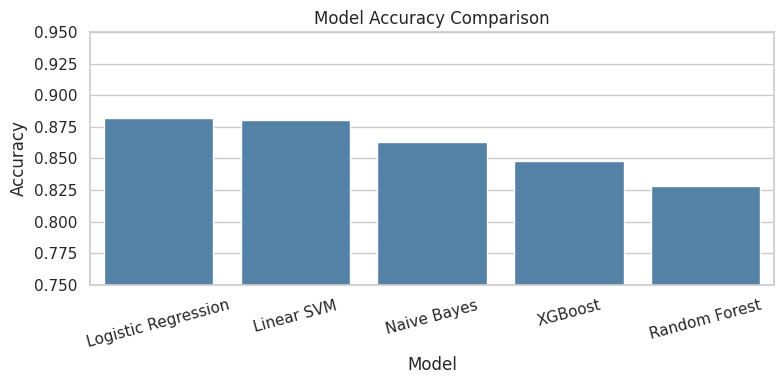

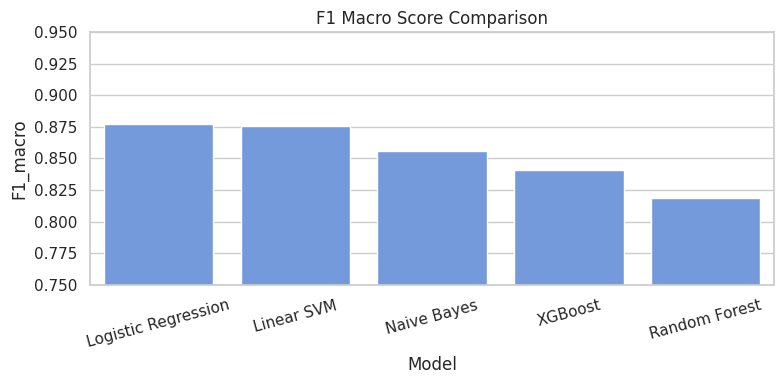

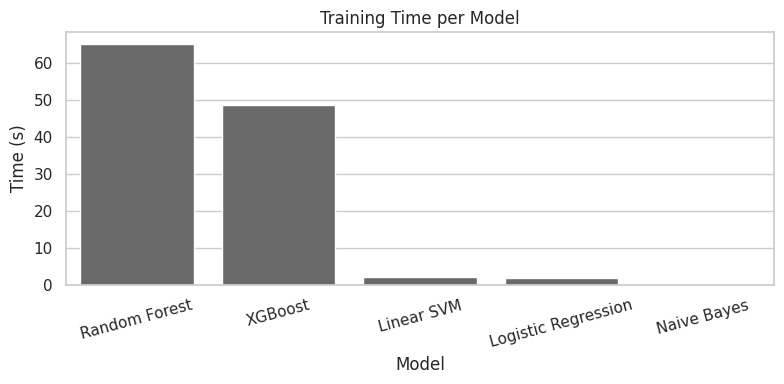

In [12]:
sns.set(style="whitegrid")

# Accuracy
plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x="Model", y="Accuracy", color='steelblue')
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=15)
plt.ylim(0.75, 0.95)
plt.tight_layout()
plt.show()

# F1 Score
plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x="Model", y="F1_macro", color='cornflowerblue')
plt.title("F1 Macro Score Comparison")
plt.xticks(rotation=15)
plt.ylim(0.75, 0.95)
plt.tight_layout()
plt.show()

# Training Time
plt.figure(figsize=(8, 4))
sns.barplot(data=results_df.sort_values("Training_Time", ascending=False),
            x="Model", y="Training_Time", color='dimgray')
plt.title("Training Time per Model")
plt.ylabel("Time (s)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [13]:
param_grid = {
    "C": [0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["liblinear"]
}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring="f1_macro")
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV F1_macro:", grid.best_score_)

best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))


Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV F1_macro: 0.8726966577393919
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      2331
           1       0.90      0.91      0.90      3401

    accuracy                           0.88      5732
   macro avg       0.88      0.88      0.88      5732
weighted avg       0.88      0.88      0.88      5732



In [14]:
sss = StratifiedShuffleSplit(n_splits=30, test_size=0.2, random_state=42)
validation_results = []

for name, model in models.items():
    metrics = {"accuracy": [], "f1": [], "runtime": []}

    for train_idx, test_idx in sss.split(df["text_clean"], df["label"]):
        X_train_split = vectorizer.fit_transform(df["text_clean"].iloc[train_idx])
        X_test_split = vectorizer.transform(df["text_clean"].iloc[test_idx])
        y_train_split = df["label"].iloc[train_idx]
        y_test_split = df["label"].iloc[test_idx]

        start = time.time()
        model.fit(X_train_split, y_train_split)
        preds = model.predict(X_test_split)
        end = time.time()

        metrics["accuracy"].append(accuracy_score(y_test_split, preds))
        metrics["f1"].append(f1_score(y_test_split, preds, average="macro"))
        metrics["runtime"].append(end - start)

    validation_results.append({
        "Model": name,
        "Accuracy (mean ± std)": f"{np.mean(metrics['accuracy']):.4f} ± {np.std(metrics['accuracy']):.4f}",
        "F1 (mean ± std)": f"{np.mean(metrics['f1']):.4f} ± {np.std(metrics['f1']):.4f}",
        "Runtime (mean ± std, s)": f"{np.mean(metrics['runtime']):.2f}s ± {np.std(metrics['runtime']):.2f}s"
    })

val_df = pd.DataFrame(validation_results)
print(val_df)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:57:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:58:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:59:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:59:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:00:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

                 Model Accuracy (mean ± std)  F1 (mean ± std)  \
0  Logistic Regression       0.8799 ± 0.0041  0.8749 ± 0.0043   
1           Linear SVM       0.8772 ± 0.0040  0.8721 ± 0.0042   
2          Naive Bayes       0.8625 ± 0.0042  0.8546 ± 0.0045   
3        Random Forest       0.8375 ± 0.0044  0.8281 ± 0.0047   
4              XGBoost       0.8521 ± 0.0045  0.8446 ± 0.0047   

  Runtime (mean ± std, s)  
0           1.18s ± 0.71s  
1           0.76s ± 0.45s  
2           0.02s ± 0.00s  
3          47.98s ± 1.58s  
4          48.44s ± 0.65s  


In [15]:
import joblib

# Vectorizatorul folosit
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")

# Modele antrenate
for name, model in models.items():
    filename = name.lower().replace(" ", "_") + ".joblib"
    joblib.dump(model, filename)


In [17]:
# Încărcăm modelul preferat
import joblib

model = joblib.load("linear_svm.joblib")
vectorizer = joblib.load("tfidf_vectorizer.joblib")
label_map_rev = {0: "negative", 1: "positive"}

print("Introduceți o propoziție (scrie 'exit' pentru a ieși):")
while True:
    text = input(">> ")
    if text.lower().strip() == "exit":
        break

    vect = vectorizer.transform([text])
    pred = model.predict(vect)[0]
    print("Predicted sentiment:", label_map_rev[pred])


Introduceți o propoziție (scrie 'exit' pentru a ieși):
>> sunt trista
Predicted sentiment: positive
>> foarte prost
Predicted sentiment: negative
>> incredibil
Predicted sentiment: positive
>> incredibil de prost
Predicted sentiment: negative
>> trist
Predicted sentiment: negative
>> trista
Predicted sentiment: positive
>> exit


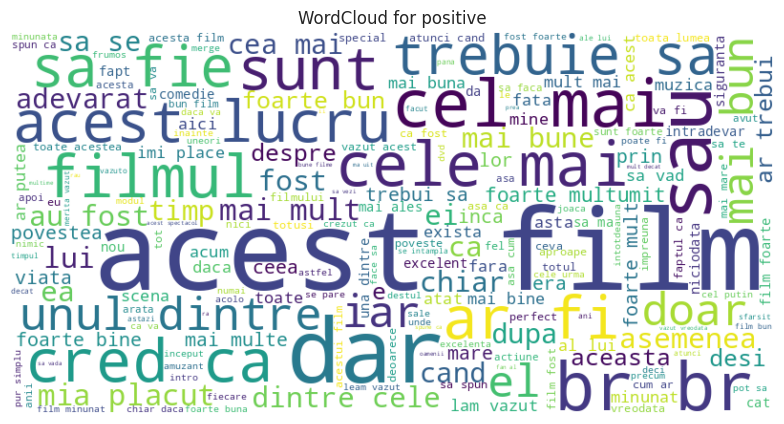

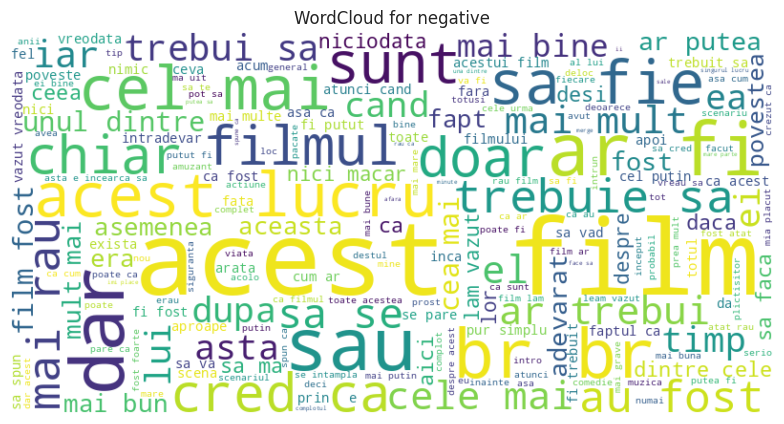

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:05:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                 Model  Accuracy  F1_macro  Training_Time
0  Logistic Regression    0.8824    0.8776           2.64
1           Linear SVM    0.8801    0.8754           1.02
2          Naive Bayes    0.8658    0.8584           0.05
6              XGBoost    0.8430    0.8345          50.82
3        Random Forest    0.8334    0.8243          61.44
4        Decision Tree    0.7456    0.7362          20.78
5                  KNN    0.5998    0.4507           9.01


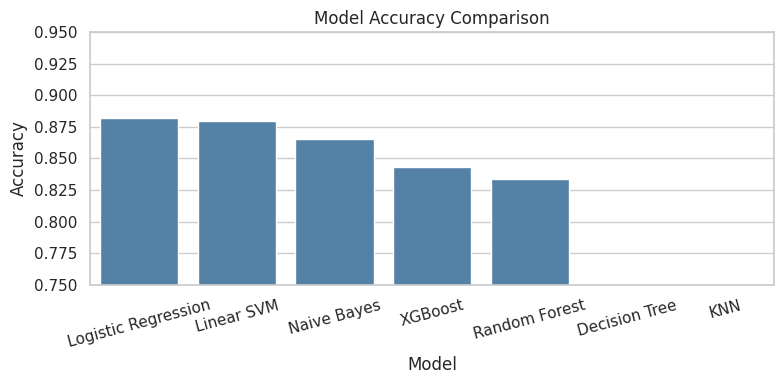

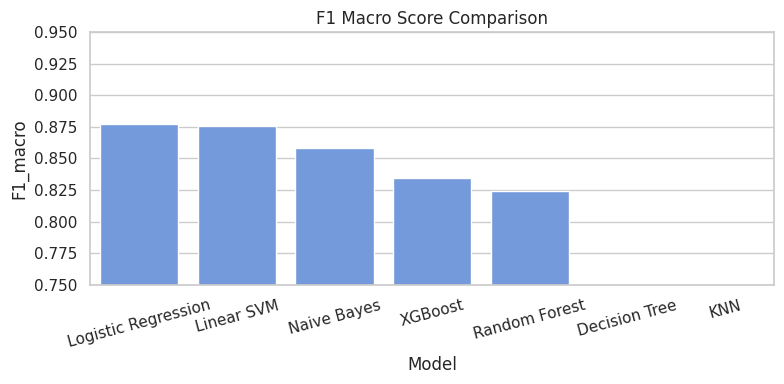

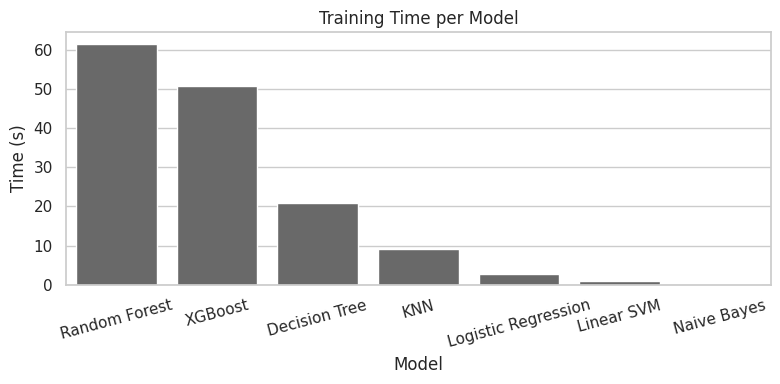

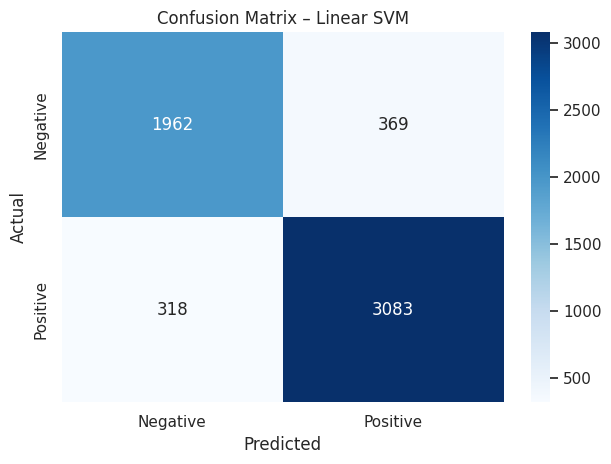

Introduceți o propoziție (scrie 'exit' pentru a ieși):
>> sunt trist
Predicted sentiment: negative
>> sunt trista
Predicted sentiment: negative
>> de ce e lumea asa de rea
Predicted sentiment: negative
>> nu pot sa cred ca am patit fix eu asa ceva
Predicted sentiment: negative
>> crezi ca o sa mearga?
Predicted sentiment: positive
>> poate nu o sa nearga
Predicted sentiment: negative
>> merge treaba?
Predicted sentiment: positive
>> merge treaba de sta
Predicted sentiment: positive
>> sunt ironic
Predicted sentiment: positive
>> nu este amuzant
Predicted sentiment: positive
>> ok este de ajuns 
Predicted sentiment: positive
>> hai acasa
Predicted sentiment: negative
>> discutam mai tarziu acasa
Predicted sentiment: positive
>> te bat de nu te vezi
Predicted sentiment: positive
>> exit


In [18]:

import pandas as pd
import numpy as np
import time
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


romanian_stopwords = set([
    'în', 'pe', 'la', 'cu', 'de', 'si', 'să', 'este', 'a', 'din', 'care', 'ce', 'un', 'o', 'nu', 'pentru'
])

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = " ".join([word for word in text.split() if word not in romanian_stopwords])
    return text


df = pd.read_csv("romanian_sentiment_dataset.csv")
label_map = {"negative": 0, "positive": 1}
df = df[df["label"].isin(label_map.keys())].copy()
df["label"] = df["label"].map(label_map)
df["text_clean"] = df["text"].astype(str).apply(clean_text)


for sentiment in df["label"].unique():
    label_name = "positive" if sentiment == 1 else "negative"
    plt.figure(figsize=(8, 5))
    sentiment_text = " ".join(df[df["label"] == sentiment]["text_clean"])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sentiment_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for {label_name}")
    plt.tight_layout()
    plt.show()


vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(df["text_clean"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(C=10, penalty='l2', solver='liblinear'),
    "Linear SVM": LinearSVC(C=1),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end = time.time()

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "F1_macro": round(f1, 4),
        "Training_Time": round(end - start, 2)
    })

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print(results_df)


sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x="Model", y="Accuracy", color='steelblue')
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=15)
plt.ylim(0.75, 0.95)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x="Model", y="F1_macro", color='cornflowerblue')
plt.title("F1 Macro Score Comparison")
plt.xticks(rotation=15)
plt.ylim(0.75, 0.95)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=results_df.sort_values("Training_Time", ascending=False),
            x="Model", y="Training_Time", color='dimgray')
plt.title("Training Time per Model")
plt.ylabel("Time (s)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


best_model = LinearSVC(C=1)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix – Linear SVM")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


print("Introduceți o propoziție (scrie 'exit' pentru a ieși):")
while True:
    text = input(">> ")
    if text.lower() == "exit":
        break
    text_clean = clean_text(text)
    vect = vectorizer.transform([text_clean])
    pred = best_model.predict(vect)
    print("Predicted sentiment:", "positive" if pred[0] == 1 else "negative")


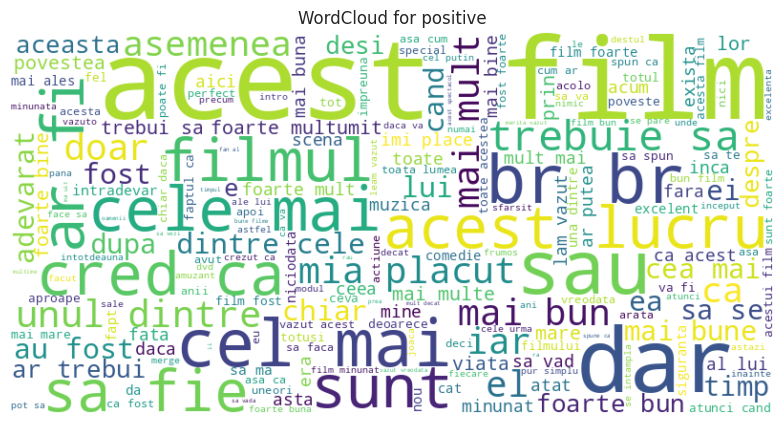

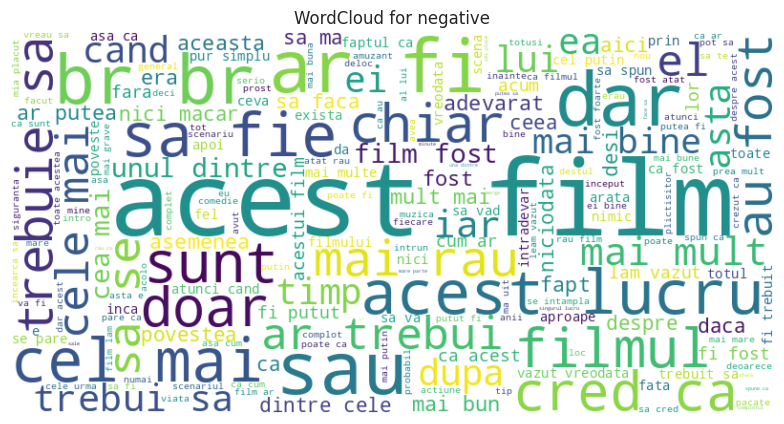

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:18:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                 Model  Accuracy  F1_macro  Training_Time
0  Logistic Regression    0.8824    0.8776           0.81
1           Linear SVM    0.8801    0.8754           0.69
2          Naive Bayes    0.8658    0.8584           0.02
6              XGBoost    0.8430    0.8345          46.59
3        Random Forest    0.8334    0.8243          48.91
4        Decision Tree    0.7439    0.7342          20.45
5                  KNN    0.5998    0.4507           9.34


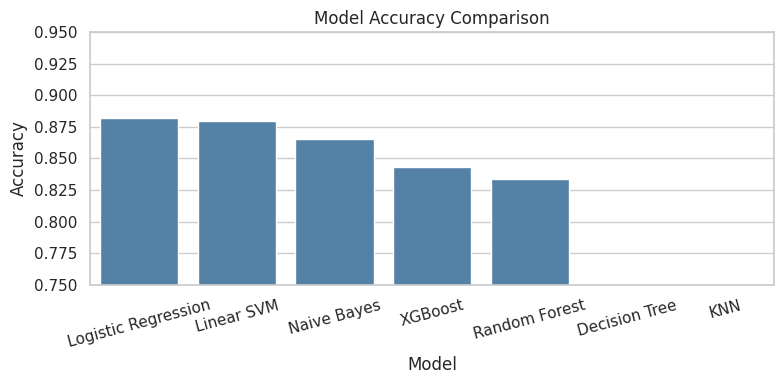

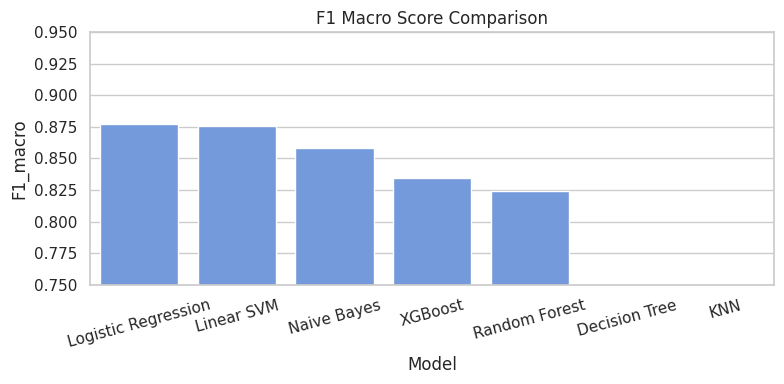

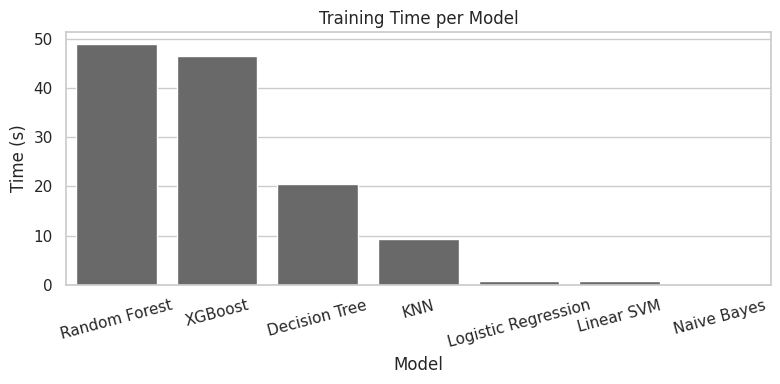

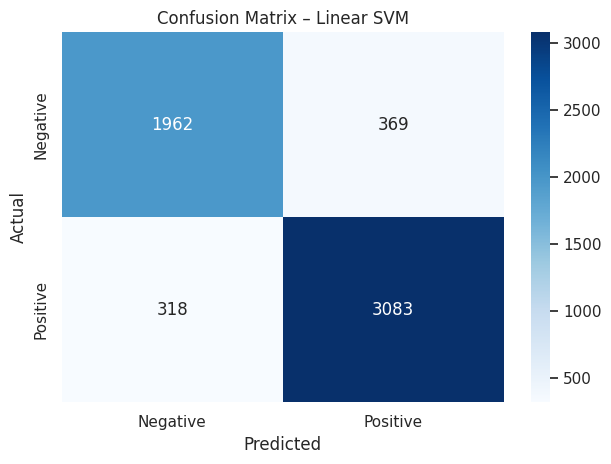

In [19]:

import pandas as pd
import numpy as np
import time
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


romanian_stopwords = set([
    'în', 'pe', 'la', 'cu', 'de', 'si', 'să', 'este', 'a', 'din', 'care', 'ce', 'un', 'o', 'nu', 'pentru'
])

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = " ".join([word for word in text.split() if word not in romanian_stopwords])
    return text


df = pd.read_csv("romanian_sentiment_dataset.csv")
label_map = {"negative": 0, "positive": 1}
df = df[df["label"].isin(label_map.keys())].copy()
df["label"] = df["label"].map(label_map)
df["text_clean"] = df["text"].astype(str).apply(clean_text)


for sentiment in df["label"].unique():
    label_name = "positive" if sentiment == 1 else "negative"
    plt.figure(figsize=(8, 5))
    sentiment_text = " ".join(df[df["label"] == sentiment]["text_clean"])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sentiment_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for {label_name}")
    plt.tight_layout()
    plt.show()


vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(df["text_clean"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


models = {
    "Logistic Regression": LogisticRegression(C=10, penalty='l2', solver='liblinear'),
    "Linear SVM": LinearSVC(C=1),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end = time.time()

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "F1_macro": round(f1, 4),
        "Training_Time": round(end - start, 2)
    })

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print(results_df)


sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x="Model", y="Accuracy", color='steelblue')
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=15)
plt.ylim(0.75, 0.95)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x="Model", y="F1_macro", color='cornflowerblue')
plt.title("F1 Macro Score Comparison")
plt.xticks(rotation=15)
plt.ylim(0.75, 0.95)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=results_df.sort_values("Training_Time", ascending=False),
            x="Model", y="Training_Time", color='dimgray')
plt.title("Training Time per Model")
plt.ylabel("Time (s)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


best_model = LinearSVC(C=1)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix – Linear SVM")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


Logistic Regression oferă cel mai bun compromis între performanță și eficiență. Are cea mai mare acuratețe și f1-macro și un timp de antrenare mic. Este alegerea preferată în situații cu date sparse și bine reprezentate TF-IDF.

Linear SVM este apropiat ca performanță, dar nu depășește Logistic Regression. Îl putem păstra ca alternativă robustă.

Naive Bayes, deși simplu și foarte rapid, are o performanță sensibil mai slabă. Este util pentru aplicații rapide, dar nu de înaltă precizie.

XGBoost și Random Forest au un timp de antrenare semnificativ mai mare fără un câștig proporțional în performanță. Justificarea lor vine doar dacă datele sunt complexe și vrem să le testăm pe ensemble-uri.

Decision Tree și KNN nu sunt potrivite în acest caz — scorurile sunt prea mici pentru a fi competitive.

In [26]:
import pandas as pd
import numpy as np
import time
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


romanian_stopwords = set([
    'în', 'pe', 'la', 'cu', 'de', 'si', 'să', 'este', 'a', 'din', 'care', 'ce', 'un', 'o', 'nu', 'pentru'
])

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = " ".join([word for word in text.split() if word not in romanian_stopwords])
    return text


df = pd.read_csv("romanian_sentiment_dataset.csv")
label_map = {"negative": 0, "positive": 1}
df = df[df["label"].isin(label_map.keys())].copy()
df["label"] = df["label"].map(label_map)
df["text_clean"] = df["text"].astype(str).apply(clean_text)


vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(df["text_clean"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


clf = SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-3, random_state=42)
clf.partial_fit(X_train, y_train, classes=np.array([0, 1]))


print("Introduceți o propoziție (scrie 'exit' pentru a ieși):")
while True:
    text = input(">> ")
    if text.lower() == "exit":
        break
    text_clean = clean_text(text)
    vect = vectorizer.transform([text_clean])
    pred = clf.predict(vect)[0]
    label_str = "positive" if pred == 1 else "negative"
    print("Predicted sentiment:", label_str)

    feedback = input("Is this correct? [y/n]: ").lower()
    if feedback == "n":
        correct_label = input("What is the correct label? [0=negative, 1=positive]: ")
        try:
            correct_label = int(correct_label)
            if correct_label in [0, 1]:
                clf.partial_fit(vect, [correct_label])
                print("Model updated with feedback!")
            else:
                print("Invalid label. Skipping update.")
        except:
            print("Invalid input. Skipping update.")


Introduceți o propoziție (scrie 'exit' pentru a ieși):
>> sunt trista
Predicted sentiment: positive
Is this correct? [y/n]: n
What is the correct label? [0=negative, 1=positive]: 0
Model updated with feedback!
>> sunt trist
Predicted sentiment: positive
Is this correct? [y/n]: n
What is the correct label? [0=negative, 1=positive]: 0
Model updated with feedback!
>> sunt trista
Predicted sentiment: positive
Is this correct? [y/n]: n
What is the correct label? [0=negative, 1=positive]: 0
Model updated with feedback!
>> sunt trista
Predicted sentiment: negative
Is this correct? [y/n]: y
>> sunt trist
Predicted sentiment: positive
Is this correct? [y/n]: exit
>> exit


In [27]:
import pandas as pd
import numpy as np
import time
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


romanian_stopwords = set([
    'în', 'pe', 'la', 'cu', 'de', 'si', 'să', 'este', 'a', 'din', 'care', 'ce', 'un', 'o', 'nu', 'pentru'
])

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = " ".join([word for word in text.split() if word not in romanian_stopwords])
    return text


df = pd.read_csv("romanian_sentiment_dataset.csv")
df = df[df["label"].isin(["positive", "negative"])].copy()
df["label"] = df["label"].map({"negative": 0, "positive": 1})
df.dropna(subset=["text", "label"], inplace=True)
df["text_clean"] = df["text"].astype(str).apply(clean_text)


vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(df["text_clean"])
y = df["label"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


clf = SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-3, random_state=42)
clf.partial_fit(X_train, y_train, classes=np.array([0, 1]))


print("Introduceți o propoziție (scrie 'exit' pentru a ieși):")
while True:
    text = input(">> ")
    if text.lower() == "exit":
        break
    text_clean = clean_text(text)
    vect = vectorizer.transform([text_clean])
    pred = clf.predict(vect)[0]
    label_str = "positive" if pred == 1 else "negative"
    print("Predicted sentiment:", label_str)

    feedback = input("Is this correct? [y/n]: ").lower()
    if feedback == "n":
        correct_label = input("What is the correct label? [0=negative, 1=positive]: ")
        try:
            correct_label = int(correct_label)
            if correct_label in [0, 1]:
                clf.partial_fit(vect, [correct_label])
                print("Model updated with feedback!")
            else:
                print("Invalid label. Skipping update.")
        except:
            print("Invalid input. Skipping update.")


Introduceți o propoziție (scrie 'exit' pentru a ieși):
>> sunt trista
Predicted sentiment: positive
Is this correct? [y/n]: exit
>> exit


In [28]:
import pandas as pd
import numpy as np
import time
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

romanian_stopwords = set([
    'în', 'pe', 'la', 'cu', 'de', 'si', 'să', 'este', 'a', 'din', 'care', 'ce', 'un', 'o', 'nu', 'pentru'
])

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = " ".join([word for word in text.split() if word not in romanian_stopwords])
    return text


df = pd.read_csv("romanian_sentiment_dataset.csv")
df = df[df["label"].isin(["positive", "negative"])].copy()
df["label"] = df["label"].map({"negative": 0, "positive": 1})
df.dropna(subset=["text", "label"], inplace=True)
df["text_clean"] = df["text"].astype(str).apply(clean_text)

# Adaugare manuala de exemple
manual_examples = [
    ("sunt trist", 0), ("sunt trista", 0), ("ma simt rau", 0), ("nu mi-a placut", 0), ("film dezamagitor", 0), ("produs slab calitativ", 0),
    ("am fost profund dezamagit", 0), ("urasc acest film", 0), ("m-a lasat rece", 0), ("nu recomand", 0), ("groaznic", 0),
    ("sunt fericit", 1), ("ma bucur", 1), ("produs excelent", 1), ("superb", 1), ("minunat", 1),
    ("film exceptional", 1), ("recomand cu caldura", 1), ("placut surprins", 1), ("extraordinar", 1), ("perfect", 1),
] * 5  # Replicam de 5 ori pentru a atinge ~100 exemple

manual_df = pd.DataFrame(manual_examples, columns=["text", "label"])
manual_df["text_clean"] = manual_df["text"].apply(clean_text)
df = pd.concat([df, manual_df], ignore_index=True)


vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(df["text_clean"])
y = df["label"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


clf = SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-3, random_state=42)
clf.partial_fit(X_train, y_train, classes=np.array([0, 1]))


print("Introduceți o propoziție (scrie 'exit' pentru a ieși):")
while True:
    text = input(">> ")
    if text.lower() == "exit":
        break
    text_clean = clean_text(text)
    vect = vectorizer.transform([text_clean])
    pred = clf.predict(vect)[0]
    label_str = "positive" if pred == 1 else "negative"
    print("Predicted sentiment:", label_str)

    feedback = input("Is this correct? [y/n]: ").lower()
    if feedback == "n":
        correct_label = input("What is the correct label? [0=negative, 1=positive]: ")
        try:
            correct_label = int(correct_label)
            if correct_label in [0, 1]:
                clf.partial_fit(vect, [correct_label])
                print("Model updated with feedback!")
            else:
                print("Invalid label. Skipping update.")
        except:
            print("Invalid input. Skipping update.")


Introduceți o propoziție (scrie 'exit' pentru a ieși):
>> sunt trista
Predicted sentiment: negative
Is this correct? [y/n]: y
>> sunt trist
Predicted sentiment: negative
Is this correct? [y/n]: y
>> ce putem face acum?
Predicted sentiment: positive
Is this correct? [y/n]: y
>> sunt entuziasmata
Predicted sentiment: negative
Is this correct? [y/n]: n
What is the correct label? [0=negative, 1=positive]: 1
Model updated with feedback!
>> de ce mi se intampla numai mie lucruri rele?
Predicted sentiment: negative
Is this correct? [y/n]: y
>> nu mai vreau sa lucrez
Predicted sentiment: positive
Is this correct? [y/n]: y
>> nu veau sa fac copii
Predicted sentiment: negative
Is this correct? [y/n]: n
What is the correct label? [0=negative, 1=positive]: 0
Model updated with feedback!
>> nu vreau sa fac copii
Predicted sentiment: positive
Is this correct? [y/n]: nu vreau copii
>> y
Predicted sentiment: positive
Is this correct? [y/n]: nu vreau copii
>> y
Predicted sentiment: positive
Is this cor

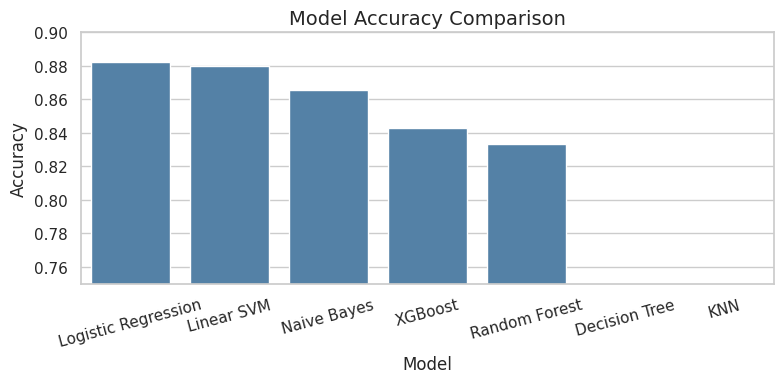

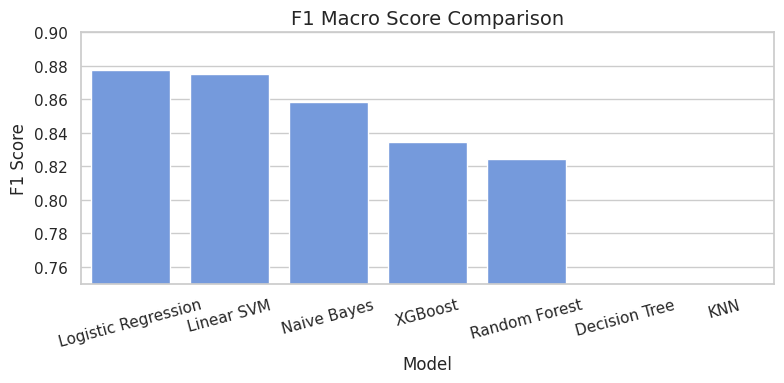

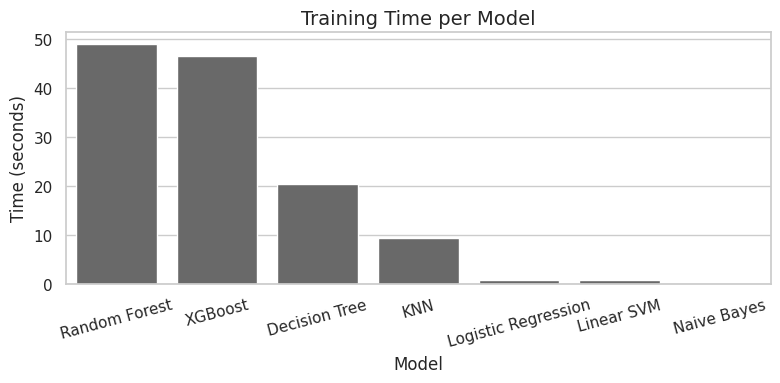

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

# Exemplu: dacă ai deja o listă cu rezultate
results_df = pd.DataFrame(results)

# Sortăm dataframe-ul după acuratețe (sau orice alt criteriu preferat)
results_df_sorted = results_df.sort_values(by="Accuracy", ascending=False)

# Create output directory if it doesn't exist
os.makedirs("plots", exist_ok=True)

# Plot 1: Accuracy
plt.figure(figsize=(8, 4))
sns.barplot(data=results_df_sorted, x="Model", y="Accuracy", color='steelblue')
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.ylim(0.75, 0.9)
plt.tight_layout()
plt.savefig("plots/accuracy_comparison.png", dpi=300)
plt.show()

# Plot 2: F1 Macro
plt.figure(figsize=(8, 4))
sns.barplot(data=results_df_sorted, x="Model", y="F1_macro", color='cornflowerblue')
plt.title("F1 Macro Score Comparison", fontsize=14)
plt.ylabel("F1 Score")
plt.xticks(rotation=15)
plt.ylim(0.75, 0.9)
plt.tight_layout()
plt.savefig("plots/f1_macro_comparison.png", dpi=300)
plt.show()

# Plot 3: Training Time
plt.figure(figsize=(8, 4))
sns.barplot(data=results_df_sorted.sort_values("Training_Time", ascending=False),
            x="Model", y="Training_Time", color='dimgray')
plt.title("Training Time per Model", fontsize=14)
plt.ylabel("Time (seconds)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("plots/training_time_comparison.png", dpi=300)
plt.show()


cap2. Author attribution

In [31]:
import pandas as pd

# Încarcă datasetul
df = pd.read_csv("ro_paragraphs_12516.csv")

# Dicționar de etichete
author_labels = {
    "Mihai Eminescu": "poet",
    "Alexandru Vlahuță": "poet",
    "Emil Gârleanu": "poet",

    "Ion Creangă": "autor",
    "Barbu Ștefănescu Delavrancea": "autor",
    "Ioan Slavici": "autor",
    "Petre Ispirescu": "autor",
    "Ion Luca Caragiale": "autor",
    "Nicolae Filimon": "autor",
    "Liviu Rebreanu": "autor",
    "Costache Negruzzi": "autor",
    # adaugă mai jos și alți autori dacă îi identifici
}

# Etichetare automată
df["label"] = df["author"].map(author_labels)

# Elimină rândurile fără etichetă (autori necunoscuți)
df = df.dropna(subset=["label"])

# Confirmare
print(df["label"].value_counts())
print(df.head())

# Opțional: salvează pentru verificare
df.to_csv("ro_paragraphs_labeled_in_code.csv", index=False)


label
autor    4692
poet     1405
Name: count, dtype: int64
        author                           title  \
0  Ion Creangă  Fata babei şi fata moşneagului   
1  Ion Creangă  Fata babei şi fata moşneagului   
2  Ion Creangă  Fata babei şi fata moşneagului   
3  Ion Creangă  Fata babei şi fata moşneagului   
4  Ion Creangă  Fata babei şi fata moşneagului   

                                           paragraph  word_count  label  
0  Erau odată un moşneag şi-o babă; şi moşneagul ...         251  autor  
1  Atunci fata babei, vicleană cum era, lua ciuru...         227  autor  
2  Într-una din zile, moşneagul, fiind foarte amă...         218  autor  
3  Atunci fetei i se făcu milă şi, luând căţeluşa...         216  autor  
4  Apoi îşi spălă frumuşel mâinile de lut şi porn...         241  autor  


In [3]:
import pandas as pd

# Citim fișierul
df = pd.read_csv("ro_paragraphs_12516.csv")

# Dicționar manual cu etichete
author_category_dict = {
    "Alexandru Vlahuță": "poet",
    "Anton Bacalbașa": "author",
    "Barbu Ştefănescu Delavrancea": "author",
    "Costache Negruzzi": "author",
    "Emil Gârleanu": "poet",
    "Emilia Plugaru": "poet",
    "George Topârceanu": "poet",
    "Ioan Slavici": "author",
    "Ion Creangă": "author",
    "Ion Luca Caragiale": "author",
    "Liviu Rebreanu": "author",
    "Mihai Eminescu": "poet",
    "Mihai Oltean": "author",
    "Mihail Sebastian": "author",
    "Nicolae Filimon": "author",
    "Nicolae Iorga": "author",
    "Panait Istrati": "author",
    "Petre Ispirescu": "author",
    "Traian Demetrescu": "poet"
}


# Funcție pentru mapare
def assign_category(author):
    return author_category_dict.get(author.strip(), "unknown")

# Aplicăm categoria
df["category"] = df["author"].apply(assign_category)

# Afișare rapidă pentru verificare
print(df[["author", "category"]].drop_duplicates().sort_values("author"))

# Salvam opțional
df.to_csv("paragraphs_with_categories.csv", index=False)


                             author category
6304              Alexandru Vlahuță     poet
12031               Anton Bacalbașa   author
374    Barbu Ştefănescu Delavrancea   author
11688             Costache Negruzzi   author
2262                  Emil Gârleanu     poet
1582                 Emilia Plugaru     poet
10591            George Topârceanu      poet
577                    Ioan Slavici   author
0                       Ion Creangă   author
1677             Ion Luca Caragiale   author
2537                 Liviu Rebreanu   author
280                  Mihai Eminescu     poet
5195                   Mihai Oltean   author
6951               Mihail Sebastian   author
2372                Nicolae Filimon   author
7609                  Nicolae Iorga   author
11189                Panait Istrati   author
995                 Petre Ispirescu   author
10922             Traian Demetrescu     poet


In [4]:
print(df["category"].value_counts())


category
author    10131
poet       2385
Name: count, dtype: int64


In [7]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, accuracy_score, f1_score
import warnings
warnings.filterwarnings("ignore")

# 1. Citim setul de date
df = pd.read_csv("ro_paragraphs_12516.csv")

# 2. Etichetare autori manuală
author_category_dict = {
    "Alexandru Vlahuță": "poet", "Anton Bacalbașa": "author",
    "Barbu Ştefănescu Delavrancea": "author", "Costache Negruzzi": "author",
    "Emil Gârleanu": "poet", "Emilia Plugaru": "poet",
    "George Topârceanu": "poet", "Ioan Slavici": "author",
    "Ion Creangă": "author", "Ion Luca Caragiale": "author",
    "Liviu Rebreanu": "author", "Mihai Eminescu": "poet",
    "Mihai Oltean": "author", "Mihail Sebastian": "author",
    "Nicolae Filimon": "author", "Nicolae Iorga": "author",
    "Panait Istrati": "author", "Petre Ispirescu": "author",
    "Traian Demetrescu": "poet"
}
df["category"] = df["author"].map(author_category_dict).fillna("unknown")
df = df[df["category"] != "unknown"].reset_index(drop=True)

# 3. Preprocesare text
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["clean_text"] = df["paragraph"].apply(preprocess)


from sklearn.preprocessing import LabelEncoder

# Codificăm etichetele ca numere pentru XGBoost
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Vectorizare cu TF-IDF (max 1000 unigrame)
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 1))
X = tfidf.fit_transform(df["clean_text"])
y = df["category"]

# 5. Împărțire train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


# 6. Definim modelele
models = {
    "Logistic Regression": LogisticRegression(C=10, penalty='l2', solver='liblinear'),
    "Linear SVM": LinearSVC(C=1),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

# 7. Antrenare + evaluare
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "F1_macro": round(f1, 4)
    })
    print(f"\n{name}\n{classification_report(y_test, y_pred)}")

# 8. Rezultate finale
results_df = pd.DataFrame(results).sort_values(by="F1_macro", ascending=False)
print("\nModel Comparison:\n", results_df)


from sklearn.metrics import classification_report

# În loopul for:
y_pred = model.predict(X_test)
print(f"\n{name}\n{classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred))}")



Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2026
           1       0.79      0.65      0.71       411

    accuracy                           0.91      2437
   macro avg       0.86      0.81      0.83      2437
weighted avg       0.91      0.91      0.91      2437


Linear SVM
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2026
           1       0.80      0.66      0.72       411

    accuracy                           0.91      2437
   macro avg       0.86      0.81      0.83      2437
weighted avg       0.91      0.91      0.91      2437


Naive Bayes
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2026
           1       0.85      0.04      0.08       411

    accuracy                           0.84      2437
   macro avg       0.84      0.52      0.49      2437
weighted avg       0.84     

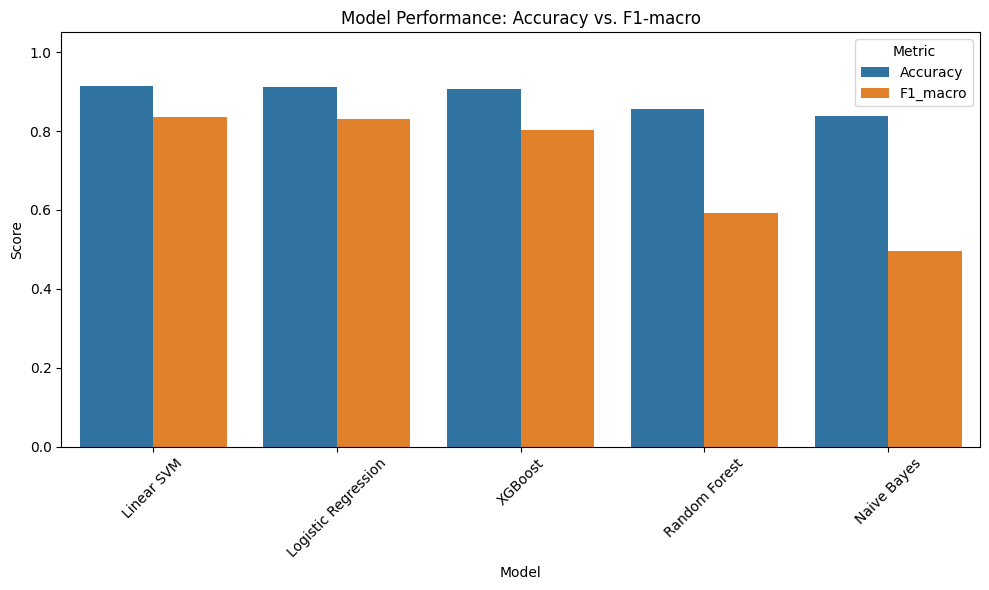

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Presupunem că ai deja acest DataFrame după evaluarea modelelor:
results_df = pd.DataFrame([
    {"Model": "Linear SVM", "Accuracy": 0.9138, "F1_macro": 0.8345},
    {"Model": "Logistic Regression", "Accuracy": 0.9118, "F1_macro": 0.8304},
    {"Model": "XGBoost", "Accuracy": 0.9064, "F1_macro": 0.8027},
    {"Model": "Random Forest", "Accuracy": 0.8564, "F1_macro": 0.5926},
    {"Model": "Naive Bayes", "Accuracy": 0.8371, "F1_macro": 0.4948}
])

# Melt pentru plotare comparativă
df_melted = pd.melt(results_df, id_vars="Model", value_vars=["Accuracy", "F1_macro"],
                    var_name="Metric", value_name="Score")

# Stil grafic
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric")
plt.title("Model Performance: Accuracy vs. F1-macro")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.tight_layout()

# Salvează imaginea
plt.savefig("model_performance_comparison.png", dpi=300)
plt.show()


Etichetarea e făcută manual, printr-un dicționar (poet si autor).

Algoritmii invata să distingă STILUL unui text și să-l clasifice ca fiind scris de un poet sau de un scriitor.

Codul clasifică automat un text nou ca fiind scris în stilul unui poet sau al unui scriitor, pe baza învățării automate.

Linear SVM și Logistic Regression au cele mai bune rezultate, indicând că există diferențe clare în stilul lexical dintre poeți și autori.

XGBoost este competitiv, dar are un cost de antrenare mai mare.

Random Forest și Naive Bayes au dificultăți mai mari în a distinge între cele două stiluri — probabil din cauza abordării mai brute și mai puțin sensibile la nuanțele lexicale.

Modelul nu are nevoie să știe explicit cine e autorul — învață trăsături stilistice din text: ritm, alegerea cuvintelor, construcții poetice vs. narative.

Este un exemplu tipic de stilometrie (authorship attribution by style).

Faptul că SVM și LR se descurcă bine înseamnă că:

Vectorizarea TF-IDF este eficientă

Poeții folosesc un set mai distinctiv de termeni sau structuri




Urmeaza in continuare

 Identificare autor concret (ex: "acesta e Eminescu", "acesta e Rebreanu")

Confusion matrix + analiza erorilor

WordCloud poet vs. autor

Compară performanțele celor două sarcini (poet/scriitor vs. autor concret)


Logistic Regression:

              precision    recall  f1-score   support

      author       0.93      0.96      0.95      2026
        poet       0.79      0.65      0.71       411

    accuracy                           0.91      2437
   macro avg       0.86      0.81      0.83      2437
weighted avg       0.91      0.91      0.91      2437


Linear SVM:

              precision    recall  f1-score   support

      author       0.93      0.97      0.95      2026
        poet       0.80      0.66      0.72       411

    accuracy                           0.91      2437
   macro avg       0.86      0.81      0.83      2437
weighted avg       0.91      0.91      0.91      2437


Naive Bayes:

              precision    recall  f1-score   support

      author       0.84      1.00      0.91      2026
        poet       0.85      0.04      0.08       411

    accuracy                           0.84      2437
   macro avg       0.84      0.52      0.49      2437
weighted avg       0.8

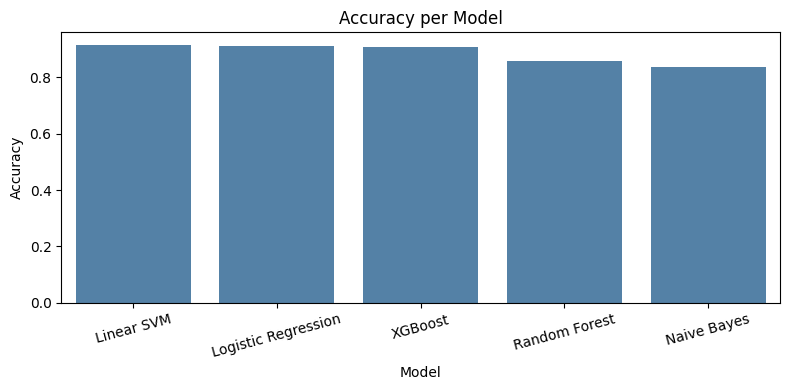

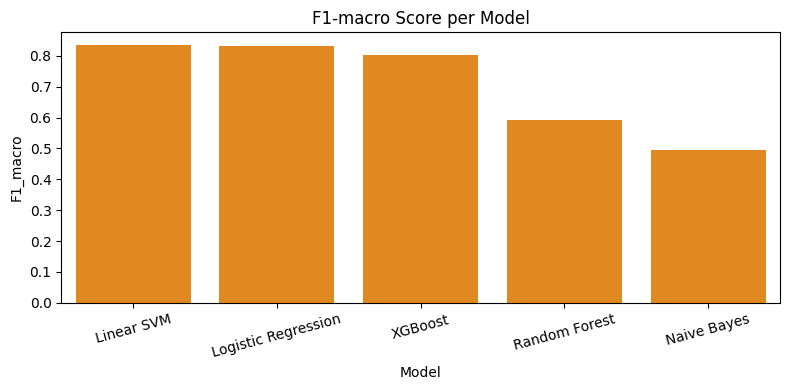

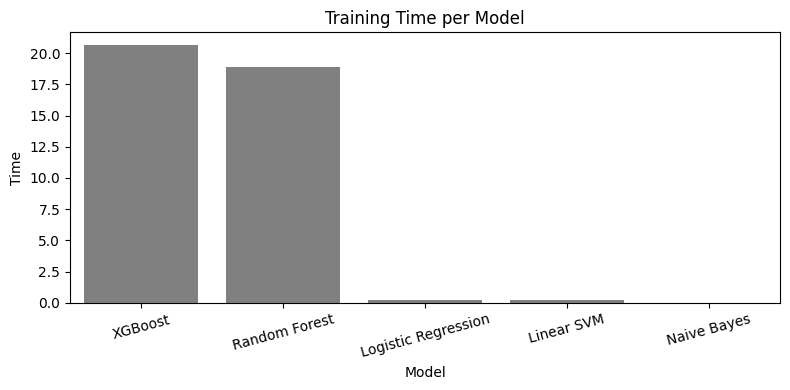

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, os, time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# 1. Load dataset
df = pd.read_csv("ro_paragraphs_12516.csv")

# 2. Author-to-category mapping
author_category_dict = {
    "Alexandru Vlahuță": "poet", "Anton Bacalbașa": "author",
    "Barbu Ştefănescu Delavrancea": "author", "Costache Negruzzi": "author",
    "Emil Gârleanu": "poet", "Emilia Plugaru": "poet",
    "George Topârceanu": "poet", "Ioan Slavici": "author",
    "Ion Creangă": "author", "Ion Luca Caragiale": "author",
    "Liviu Rebreanu": "author", "Mihai Eminescu": "poet",
    "Mihai Oltean": "author", "Mihail Sebastian": "author",
    "Nicolae Filimon": "author", "Nicolae Iorga": "author",
    "Panait Istrati": "author", "Petre Ispirescu": "author",
    "Traian Demetrescu": "poet"
}
df["category"] = df["author"].map(author_category_dict)
df = df.dropna(subset=["category"]).reset_index(drop=True)

# 3. Preprocessing
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["clean_text"] = df["paragraph"].astype(str).apply(preprocess)

# 4. Encode labels
label_map = {"author": 0, "poet": 1}
df["label"] = df["category"].map(label_map)

# 5. TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,1))
X = vectorizer.fit_transform(df["clean_text"])
y = df["label"]

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 7. Models
models = {
    "Logistic Regression": LogisticRegression(C=10, solver='liblinear'),
    "Linear SVM": LinearSVC(C=1),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

# 8. Training & evaluation
results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end = time.time()

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"\n{name}:\n")
    print(classification_report(y_test, y_pred, target_names=["author", "poet"]))

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1_macro": f1,
        "Time": end - start
    })

# 9. Plot results
results_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False)
os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x="Model", y="Accuracy", color='steelblue')
plt.title("Accuracy per Model")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("plots/accuracy_authorship.png")
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x="Model", y="F1_macro", color='darkorange')
plt.title("F1-macro Score per Model")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("plots/f1macro_authorship.png")
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=results_df.sort_values("Time", ascending=False), x="Model", y="Time", color='gray')
plt.title("Training Time per Model")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("plots/training_time_authorship.png")
plt.show()


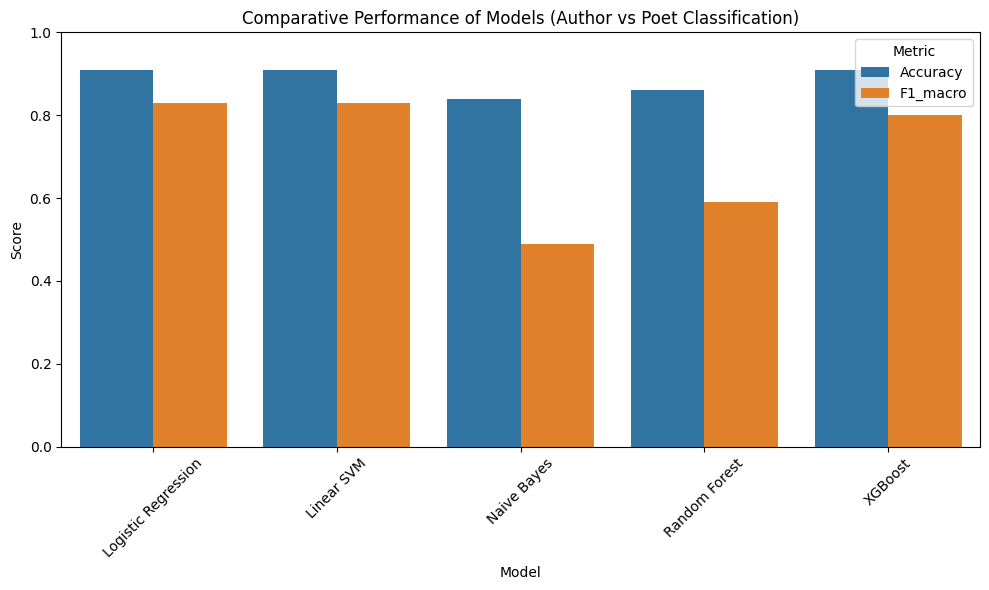

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definim rezultatele
results_data = {
    "Model": ["Logistic Regression", "Linear SVM", "Naive Bayes", "Random Forest", "XGBoost"],
    "Accuracy": [0.91, 0.91, 0.84, 0.86, 0.91],
    "F1_macro": [0.83, 0.83, 0.49, 0.59, 0.80]
}

results_df = pd.DataFrame(results_data)

# Vizualizare comparativă
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars="Model", var_name="Metric", value_name="Score"),
            x="Model", y="Score", hue="Metric")
plt.title("Comparative Performance of Models (Author vs Poet Classification)")
plt.ylabel("Score")
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("model_comparison_binary_poet_author.png")
plt.show()


Cele mai bune rezultate le au Logistic Regression și Linear SVM (acuratețe și F1 macro de 0.91/0.83).

XGBoost este foarte aproape, dar are F1 macro ușor mai mic, ceea ce indică un dezechilibru în performanță între clase.

Naive Bayes performează slab pe clasa minoritară (poet) – f1-score de doar 0.08 pentru poet.

Random Forest tinde să favorizeze masiv clasa majoritară (author), iar recall-ul pentru poet e foarte mic (0.15).

In [12]:
import pandas as pd
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score, f1_score

# 1. Load the dataset
df = pd.read_csv("ro_paragraphs_12516.csv")

# 2. Drop rows with unknown or missing authors
df = df[df["author"].notnull()]
df = df[df["author"] != "unknown"]

# 3. Text preprocessing
def preprocess(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)  # remove digits
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["paragraph"].astype(str).apply(preprocess)

# 4. TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df["clean_text"])
y = df["author"]

# 5. Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 6. Define models (XGBoost removed)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# 7. Train and evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    print(f"\n{name}:\n", classification_report(y_test, y_pred))
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "F1_macro": round(f1, 4)
    })

# 8. Results comparison
results_df = pd.DataFrame(results).sort_values(by="F1_macro", ascending=False)
print("\nModel Comparison:\n", results_df)




Logistic Regression:
                               precision    recall  f1-score   support

           Alexandru Vlahuță       0.85      0.85      0.85       129
             Anton Bacalbașa       0.71      0.67      0.69        97
Barbu Ştefănescu Delavrancea       0.79      0.85      0.82       149
           Costache Negruzzi       0.83      0.83      0.83        69
               Emil Gârleanu       0.84      0.66      0.74        71
              Emilia Plugaru       0.97      0.96      0.97        76
          George Topârceanu        0.79      0.35      0.48        66
                Ioan Slavici       0.84      0.94      0.89       343
                 Ion Creangă       0.96      0.78      0.86        85
          Ion Luca Caragiale       0.75      0.80      0.78       117
              Liviu Rebreanu       0.83      0.85      0.84       124
              Mihai Eminescu       0.85      0.70      0.77        81
                Mihai Oltean       0.60      0.21      0.32       

Linear SVM are cea mai mare acuratețe, ceea ce indică o performanță solidă pe ansamblul setului de test.

Logistic Regression este aproape, dar ceva mai slab pe clase mai mici (autorii cu puține exemple).

Naive Bayes și Random Forest au performanță modestă, mai ales în clasificarea autorilor cu stiluri mai subtile sau date puține.

Linear SVM este cel mai performant model, are acuratețe ridicată (89.9%) și scor F1_macro excelent (0.86) este foarte bun pentru autori cu seturi mari de date: Nicolae Iorga (f1 = 0.96), Ioan Slavici (0.94), Petre Ispirescu (0.97), este surprinzător de eficient și pentru autori mai rari: Mihai Oltean (f1 = 0.73 cu doar 14 exemple!), dar are probleme moderate cu: George Topârceanu și Traian Demetrescu, probabil din cauza stilului ambiguu sau datelor mai puține.

Logistic Regression are scor F1_macro de 0.78 este decent, dar vizibil sub Linear SVM, are s-probleme vizibile la George Topârceanu (f1 = 0.48) și Mihai Oltean (f1 = 0.32), este mai robust pe medie, dar mai slab în extreme (autori rari sau necaracteristici).

Naive Bayes are scoruri scăzute: f1 = 0.54 (macro), acuratețe = 68%, dar suferă la clasele dezechilibrate și la autori care nu folosesc cuvinte “tipice” (stiluri neclare).

Exemple:

Traian Demetrescu: f1 = 0.20

George Topârceanu: f1 = 0.09

Merge decent la Nicolae Iorga și Emilia Plugaru pentru ca sunt autori cu vocabular distinctiv.

 Random Forest are acuratețe generală slabă: 67%, dar e foarte slab în detectarea autorilor subtili sau cu puține date.

Traian Demetrescu: f1 = 0.14

George Topârceanu: f1 = 0.19

Are bias spre clasele mari (Iorga, Slavici), ceea ce duce la dezechilibru.

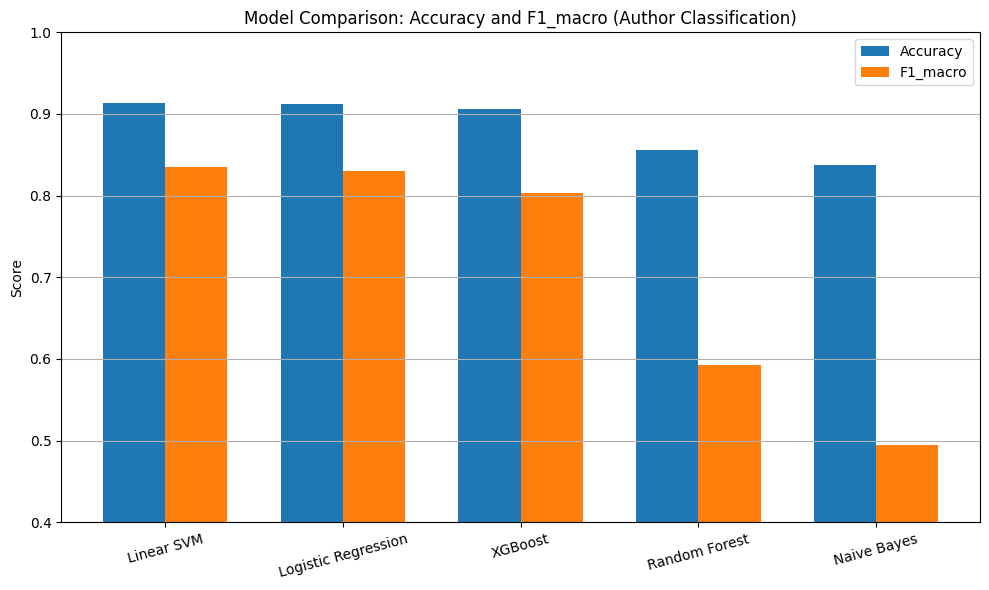

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Datele
models = ["Linear SVM", "Logistic Regression", "XGBoost", "Random Forest", "Naive Bayes"]
accuracy = [0.9138, 0.9118, 0.9064, 0.8564, 0.8371]
f1_macro = [0.8345, 0.8304, 0.8027, 0.5926, 0.4948]

# Grafic comparativ
x = range(len(models))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar([p - width/2 for p in x], accuracy, width=width, label='Accuracy')
plt.bar([p + width/2 for p in x], f1_macro, width=width, label='F1_macro')

plt.xticks(x, models, rotation=15)
plt.ylabel("Score")
plt.ylim(0.4, 1.0)
plt.title("Model Comparison: Accuracy and F1_macro (Author Classification)")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

# Salvare
plt.savefig("author_classification_comparison.png", dpi=300)
plt.show()


In [14]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Load dataset
df = pd.read_csv("ro_paragraphs_12516.csv")

# Manual label for poet/author
author_category_dict = {
    "Alexandru Vlahuță": "poet", "Anton Bacalbașa": "author",
    "Barbu Ştefănescu Delavrancea": "author", "Costache Negruzzi": "author",
    "Emil Gârleanu": "poet", "Emilia Plugaru": "poet",
    "George Topârceanu": "poet", "Ioan Slavici": "author",
    "Ion Creangă": "author", "Ion Luca Caragiale": "author",
    "Liviu Rebreanu": "author", "Mihai Eminescu": "poet",
    "Mihai Oltean": "author", "Mihail Sebastian": "author",
    "Nicolae Filimon": "author", "Nicolae Iorga": "author",
    "Panait Istrati": "author", "Petre Ispirescu": "author",
    "Traian Demetrescu": "poet"
}
df["category"] = df["author"].map(author_category_dict).fillna("unknown")
df = df[df["category"] != "unknown"].reset_index(drop=True)

# Preprocessing
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["clean_text"] = df["paragraph"].astype(str).apply(preprocess)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=2000)
X = tfidf.fit_transform(df["clean_text"])
y = df["author"]

# Encode authors for XGBoost
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Evaluate
for name, model in models.items():
    print(f"\n{name}")
    if name == "XGBoost":
        model.fit(X_train_enc, y_train_enc)
        y_pred = model.predict(X_test_enc)
        y_true = y_test_enc
        y_labels = label_encoder.inverse_transform(y_pred)
        print(classification_report(label_encoder.inverse_transform(y_true), y_labels))
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred))



Logistic Regression
                              precision    recall  f1-score   support

           Alexandru Vlahuță       0.85      0.89      0.87       129
             Anton Bacalbașa       0.89      0.75      0.82        97
Barbu Ştefănescu Delavrancea       0.83      0.84      0.83       149
           Costache Negruzzi       0.92      0.84      0.88        69
               Emil Gârleanu       0.92      0.68      0.78        71
              Emilia Plugaru       1.00      0.97      0.99        76
                Ioan Slavici       0.88      0.94      0.91       343
                 Ion Creangă       0.92      0.82      0.87        85
          Ion Luca Caragiale       0.79      0.85      0.81       117
              Liviu Rebreanu       0.83      0.81      0.82       124
              Mihai Eminescu       0.80      0.63      0.70        81
                Mihai Oltean       0.60      0.21      0.32        14
            Mihail Sebastian       0.94      0.96      0.95       13

Linear SVM (cel mai performant) are precizie ridicată la aproape toți autorii, recall-ul este excelent, chiar și la clase cu mai puține exemple (Traian Demetrescu: 0.77), F1-score mediu/macro ridicat (aprox. 0.89) ceea ce indică echilibru între precizie și acoperire, are stabilitate mare între clase, performanța nu scade drastic la autorii minoritari, este ideal ca model de bază pentru deployment.

Logistic Regression este foarte apropiat de SVM, dar puțin mai slab pe clase minoritare(ex.: Mihai Oltean are f1=0.32 vs. 0.78 la SVM ceea ce semnifică instabilitate în clasificarea autorilor rari), dar este foarte bun pentru interpretabilitate, coeficienții pot fi inspectați pentru feature importance, poate fi preferat când explicabilitatea contează mai mult decât maximizarea scorului.

XGBoost are performanță bună, dar nu excepțională comparat cu SVM si Logistic Regression, are tendința de a favoriza clasele mari (ex.: Nicolae Iorga, Ioan Slavici), are recall bun, dar F1 mediu (aprox. 0.76) trage semnal că nu se descurcă consistent pe toți autorii, F1 sub 0.6 pentru autori precum Mihai Eminescu, Mihai Oltean, Traian Demetrescu.

Naive Bayes este extrem de dezechilibrat cu f1 foarte bun pentru autori cu stil distinct (Emilia Plugaru, Nicolae Iorga), dar dezastruos pentru alții.

Ex: Mihai Eminescu: recall 0.11: modelul nu reușește să-l recunoască aproape deloc, este probabil afectat de presupunerile naive de independență a cuvintelor, nu funcționează bine cu texte literare mai complexe.

Random Forest are recall foarte slab pentru majoritatea autorilor, deși precizia pe alocuri este ok.

Ex: Traian Demetrescu: recall 0.08 deci este practic ignorat.

Tinde să supraînvețe pe clasele frecvente și să ignore clasele rare.

Nerecomandat pentru această sarcină fără optimizări serioase (e.g., class weights, feature selection).

In concluzie cel mai bun model este Linear SVM, are robustețe, precizie și acoperire bună, este ideal pentru clasificare multi-clasă când datele sunt echilibrate (sau aproape).

Logistic Regression este si el foarte bun ca model alternativ, mai ales dacă ai nevoie de interpretabilitate.

Modele de evitat:
Naive Bayes și Random Forest pentru ca ambele eșuează să recunoască consistent autorii mai puțin frecvenți și prezintă variații mari de performanță.


Logistic Regression
                              precision    recall  f1-score   support

           Alexandru Vlahuță       0.86      0.89      0.88       129
             Anton Bacalbașa       0.80      0.76      0.78        97
Barbu Ştefănescu Delavrancea       0.81      0.86      0.83       149
           Costache Negruzzi       0.81      0.83      0.82        69
               Emil Gârleanu       0.91      0.68      0.77        71
              Emilia Plugaru       0.99      0.97      0.98        76
           George Topârceanu       0.92      0.50      0.65        66
                Ioan Slavici       0.86      0.95      0.90       343
                 Ion Creangă       0.97      0.78      0.86        85
          Ion Luca Caragiale       0.78      0.84      0.81       117
              Liviu Rebreanu       0.85      0.85      0.85       124
              Mihai Eminescu       0.86      0.69      0.77        81
                Mihai Oltean       0.67      0.14      0.24        1

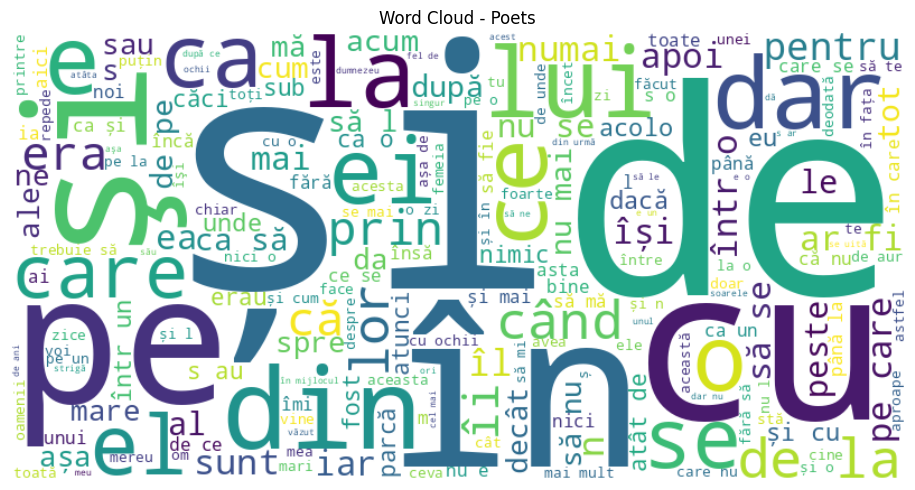

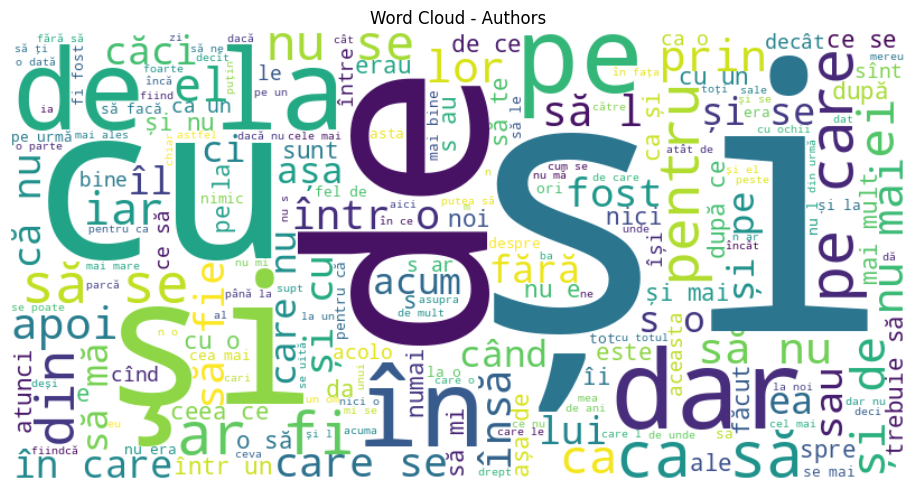

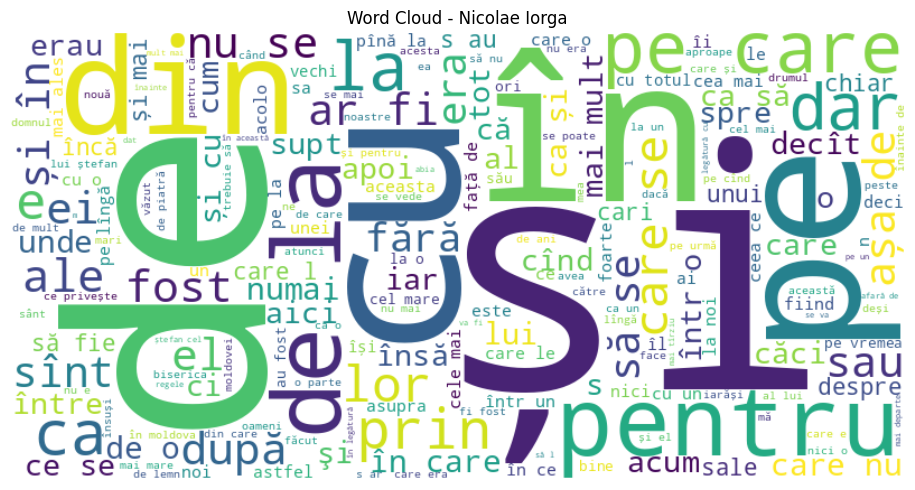

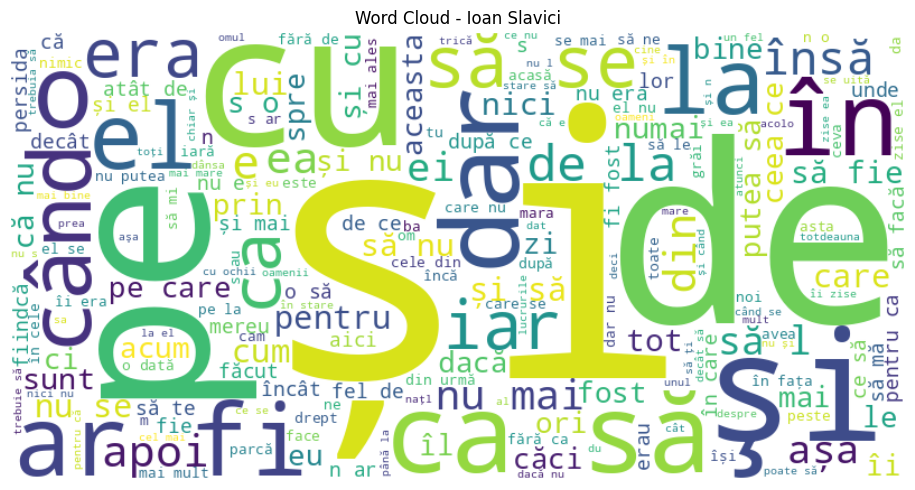

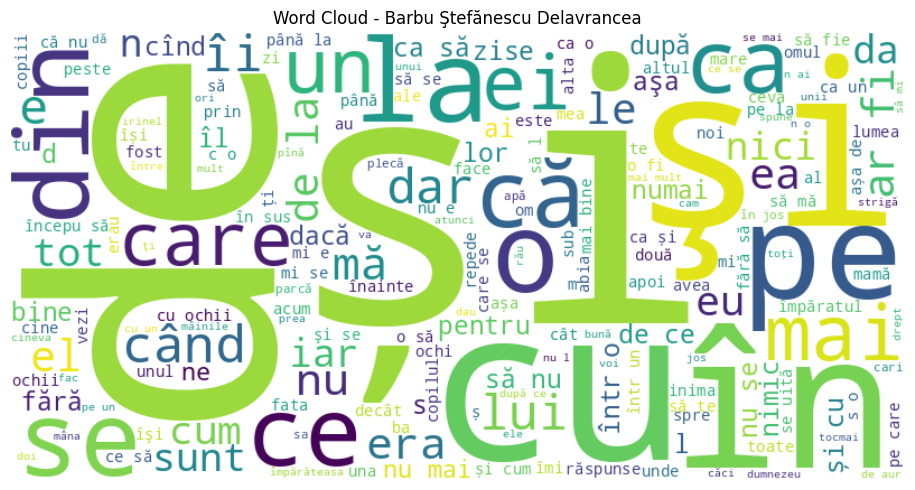

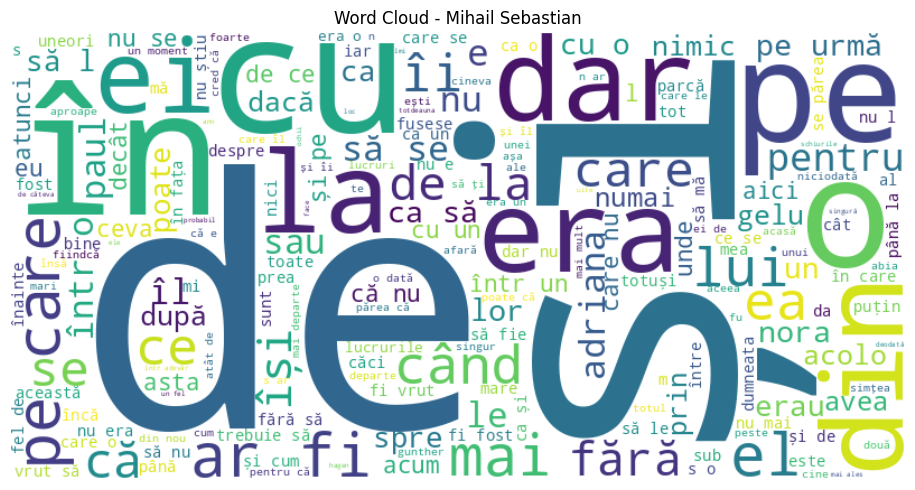

In [15]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# 1. Citirea datelor
df = pd.read_csv("ro_paragraphs_12516.csv")

# 2. Etichetare manuală
author_category_dict = {
    "Alexandru Vlahuță": "poet", "Anton Bacalbașa": "author",
    "Barbu Ştefănescu Delavrancea": "author", "Costache Negruzzi": "author",
    "Emil Gârleanu": "poet", "Emilia Plugaru": "poet",
    "George Topârceanu": "poet", "Ioan Slavici": "author",
    "Ion Creangă": "author", "Ion Luca Caragiale": "author",
    "Liviu Rebreanu": "author", "Mihai Eminescu": "poet",
    "Mihai Oltean": "author", "Mihail Sebastian": "author",
    "Nicolae Filimon": "author", "Nicolae Iorga": "author",
    "Panait Istrati": "author", "Petre Ispirescu": "author",
    "Traian Demetrescu": "poet"
}
df["author"] = df["author"].str.strip()
df["category"] = df["author"].map(author_category_dict).fillna("unknown")
df = df[df["category"] != "unknown"]

# 3. Preprocesare text
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["clean_text"] = df["paragraph"].astype(str).apply(preprocess)

# 4. TF-IDF și codificare labeluri
tfidf = TfidfVectorizer(max_features=2000)
X = tfidf.fit_transform(df["clean_text"])
y = df["author"]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 5. Împărțire train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# 6. Modele clasice
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# 7. Antrenare și evaluare
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 8. Word Clouds pe categorii
def generate_wordcloud(text_series, title):
    wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text_series))
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

generate_wordcloud(df[df['category'] == 'poet']['clean_text'], "Word Cloud - Poets")
generate_wordcloud(df[df['category'] == 'author']['clean_text'], "Word Cloud - Authors")

# 9. Word Clouds per autor (top 4 autori cu cele mai multe exemple)
top_authors = df['author'].value_counts().head(4).index.tolist()
for author in top_authors:
    author_texts = df[df['author'] == author]['clean_text']
    generate_wordcloud(author_texts, f"Word Cloud - {author}")


Linear SVM este cel mai echilibrat model cu acuratețe generală: 0.92, este excelentă, are macro F1: aprox. 0.89, este foarte apropiat de ideal în scenarii multi-class, se remarcă prin robustețe pe toate clasele, chiar și pe cele cu puține exemple.

Ex:

Traian Demetrescu: F1 = 0.85

Mihai Oltean: F1 = 0.73

Nicio clasă nu este complet ignorată sau drastic penalizată.

Ideal pentru deployment pentru ca este stabil, scalabil și consistent, dar are limita, explicațiile nu sunt la fel de clare ca în regresie logistică.

Logistic Regression este o alternativă solidă și interpretabilă, cu o acuratețe de 0.87 ceea ce o face foarte bună, are macro F1: aprox. 0.81, este decent, dar sub SVM.
Excelează pe clase frecvente (Slavici, Iorga, Sebastian) dar pierde din precizie pe clasele rare:

Ex:

Mihai Oltean: F1 = 0.24

Traian Demetrescu: F1 = 0.73

Are avantaj major pentru ca coeficienții pot fi interpretați si este foarte util dacă vrem sa vedem ce termeni influențează predicția.


Modele mai slabe:

Naive Bayes cu accuracy: aprox. 0.69, macro F1 sub 0.55.

Extrem de polarizat, merge surprinzător de bine pe unii autori, dar dezastru pe alții.

Ex:

Nicolae Iorga: F1 = 0.83

Mihai Eminescu: F1 = 0.27

Traian Demetrescu: F1 = 0.14

Mihai Oltean: complet ignorat (0.00)

Problema este ca algoritmul presupune independența cuvintelor (ceea ce în texte literare nu funcționează).



Random Forest este si el slab cu accuracy: 0.67, sub așteptări.

Macro F1: 0.53, scăzut.

Acesta ignoră complet clasele rare:

Mihai Oltean: F1 = 0.25

Traian Demetrescu: F1 = 0.07

Algoritmul tinde să supraînvețe pe clasele mari (Iorga, Slavici) și să ignore restul.

Recomandat doar dacă aplici optimizări serioase: class weights, feature engineering, undersampling etc.

XGBoost este un algoritm mediu, dar stabil cu accuracy de 0.82, Macro F1 de 0.76, are predicții relativ stabile dar sub Linear SVM.

E decent pe majoritatea autorilor dar:

Eminescu, Oltean, Demetrescu, au scoruri de F1 sub 0.6.

Este model sofisticat, dar aici nu aduce un salt real în performanță, putin dezamagitor.



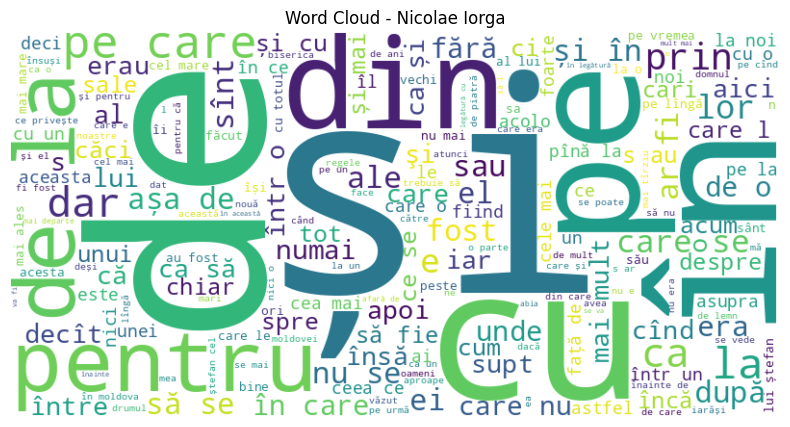

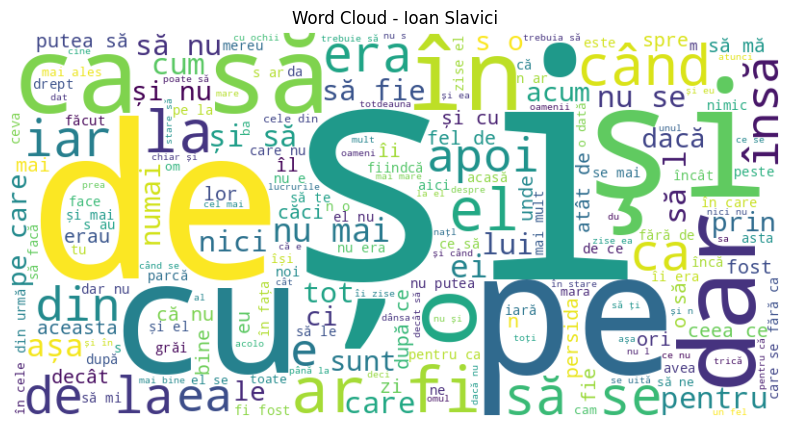

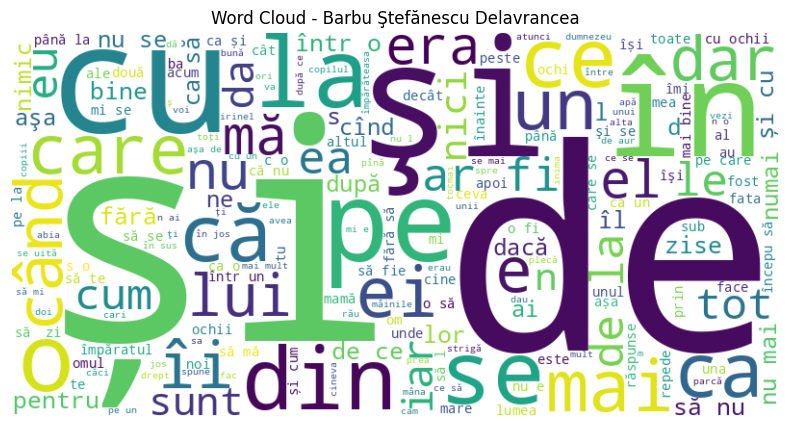

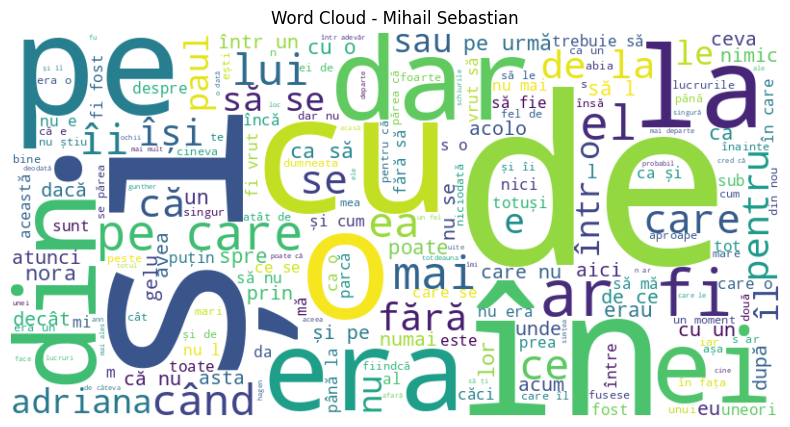

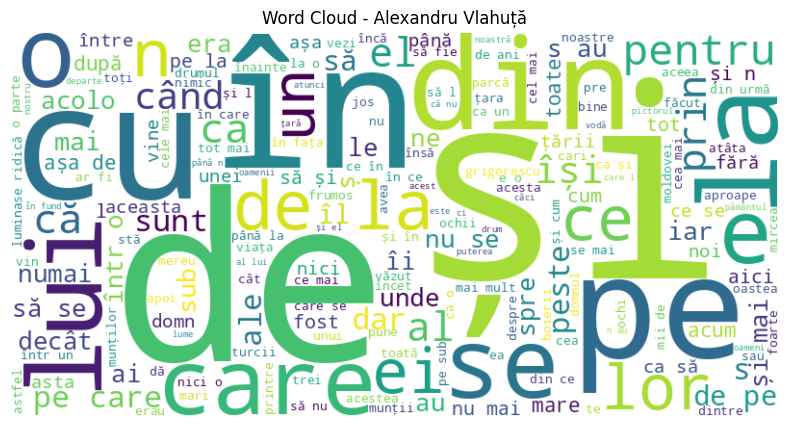

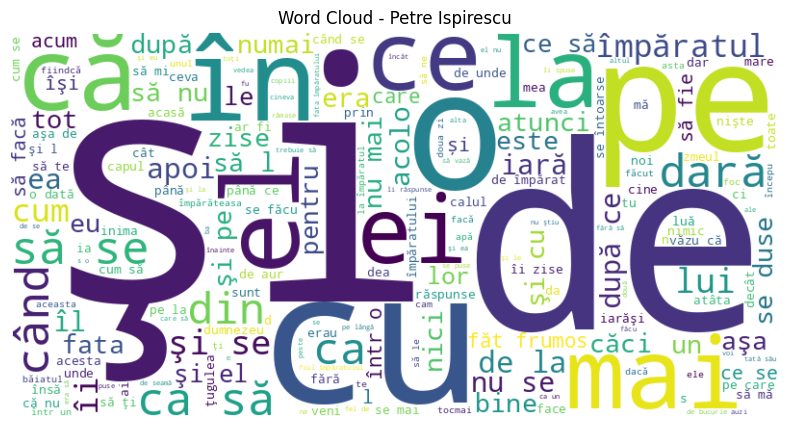

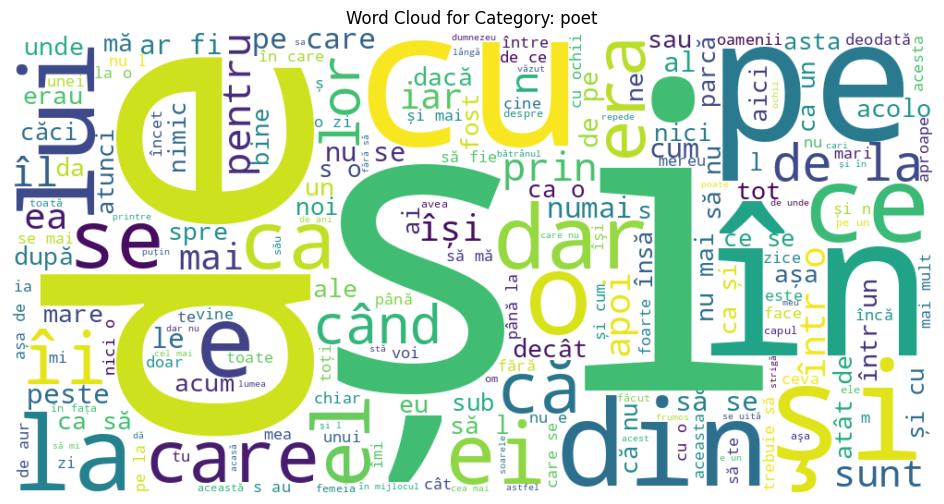

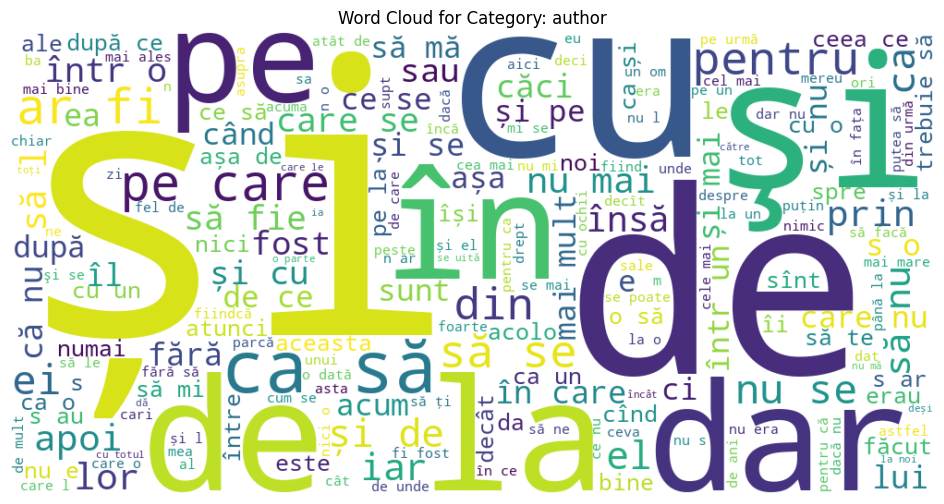

In [16]:
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Încarcă fișierul
df = pd.read_csv("ro_paragraphs_12516.csv")

# 2. Elimină rânduri invalide
df = df[df["author"].notnull()]
df = df[df["author"] != "unknown"]
df["paragraph"] = df["paragraph"].astype(str)

# 3. Curățare text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\săâîșț]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df["clean_text"] = df["paragraph"].apply(clean_text)
df = df[df["clean_text"] != ""]  # Exclude text gol

# 4. Adaugă manual categoriile
author_category_dict = {
    "Alexandru Vlahuță": "poet",
    "Anton Bacalbașa": "author",
    "Barbu Ştefănescu Delavrancea": "author",
    "Costache Negruzzi": "author",
    "Emil Gârleanu": "poet",
    "Emilia Plugaru": "poet",
    "George Topârceanu": "poet",
    "Ioan Slavici": "author",
    "Ion Creangă": "author",
    "Ion Luca Caragiale": "author",
    "Liviu Rebreanu": "author",
    "Mihai Eminescu": "poet",
    "Mihai Oltean": "author",
    "Mihail Sebastian": "author",
    "Nicolae Filimon": "author",
    "Nicolae Iorga": "author",
    "Panait Istrati": "author",
    "Petre Ispirescu": "author",
    "Traian Demetrescu": "poet"
}
df["category"] = df["author"].map(author_category_dict).fillna("unknown")

# 5. Word clouds pentru cei mai frecvenți 6 autori
top_authors = df["author"].value_counts().head(6).index.tolist()
for author in top_authors:
    text = " ".join(df[df["author"] == author]["clean_text"])
    if text:
        wc = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud - {author}")
        plt.show()

# 6. Word cloud pe categorii
for category in ["poet", "author"]:
    text = " ".join(df[df["category"] == category]["clean_text"])
    if text:
        wc = WordCloud(width=1000, height=500, background_color="white").generate(text)
        plt.figure(figsize=(12, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for Category: {category}")
        plt.show()


Frecventa si tipologia cuvintelor functionale:

Atat poetii, cat si autorii folosesc cuvinte functionale comune: „si”, „de”, „cu”, „in”, „la”, „pe”, „care”, „pentru”, „din”.

Diferenta este subtila, dar semnificativa in frecventa:

Poetii par sa foloseasca mult „iar”, „numai”, „chiar”, „unde”, „acum”, ceea ce indica o tendinta spre evocare, opozitie, detalii temporale si spatiale.

Autorii insista pe constructii mai narative: „fost”, „facut”, „trebuie”, „spune”, ceea ce reflecta discurs narativ, actiune si descriere.

Cuvinte expresive si emotive:

Poetii: „mă”, „suflet”, „lumea”, „inima”, „vise”, „dor”, „lumina” (absente la prozatori), ceea ce subliniaza introspectia si lirismul.

Autorii: apar cuvinte descriptive si narative: „ochii”, „drumul”, „casa”, „copilul”, „mana”, „fata” – arata preocuparea pentru context, actiune si relatie.

Constructii stilistice:

Poetii folosesc mai frecvent structuri scurte, uneori fragmentare, pline de cuvinte de legatura afective: „dar”, „si”, „iar”, „chiar”.

Autorii prefera claritatea structurii narative: „pentru ca”, „a spus”, „era”, „acesta”, „fata de”, „in timp ce”.

Analiza individuala, stiluri distincte:

Nicolae Iorga are limbaj istoric, formal si descriptiv.

Frecventa cuvintelor ca „unui”, „domnul”, „vechi”, „drumul”, „biserica” indica un stil didactic, documentar.

Apare foarte des „fost”, „in vremea”, „asa ca”, „pana la”, deci un discurs cu cronologie si intentie explicativa.

Ioan Slavici pune accent pe relatii interumane: „el”, „ea”, „copiii”, „omul”.

Verbe frecvente: „era”, „fie”, „putea”, „zise”, are ton narativ, cu multa actiune si dialog.

Cuvinte afective: „bine”, „asa”, „nici”, „totdeauna”, indica un stil uman, cald, reflexiv.

Barbu Stefanescu Delavrancea foloseste limbaj teatral, dramatic: „zise”, „fata”, „imparatul”, „nu mai”, „deodata”, „striga”.

Se remarca elemente ale basmului si dialogului oral.

Combinatie de cuvinte cu sens epic si fantastic.

Mihail Sebastian e reflexiv, urban, cu dialog si nuante moderne: „nimic”, „poate”, „totusi”, „paul”, „adriana”, „eu”.

Cuvinte ca „acolo”, „era”, „sa fie”, „niciodata”, indica interiorizare, observatie.

Temele par mai contemporane si relationale.

Alexandru Vlahuta utilizeaza descrieri ample, termeni geografici: „muntii”, „drumul”, „tarii”, „pamantul”.

Constructii descriptive: „sub cerul”, „pe marginea”, „spre soare”, are stil patriotic si contemplativ.

Petre Ispirescu este cu specific oralitatii si basmului: „imparatul”, „fata”, „zise”, „fiul”, „calul”, „binefacatorul”.

Frecvente expresii traditionale, directe, cu iz popular.

Concluzie:

Poetii se axeaza pe emotie, moment, impresie si relatie subiectiva cu lumea. Lexicul este marcat de adverbe si pronume afective, iar constructiile sunt simple, dar incarcate simbolic.

Autorii construiesc contexte, actiuni si relatii intre personaje. Lexicul este orientat spre naratiune, actiune si descriere, cu verbe la trecut, substantive concrete si structuri gramaticale mai complexe.

Word cloud-urile confirma faptul ca analiza automata pe baza TF-IDF si clasificare autorala poate functiona foarte bine cand stilul lexical este atat de diferentiat.

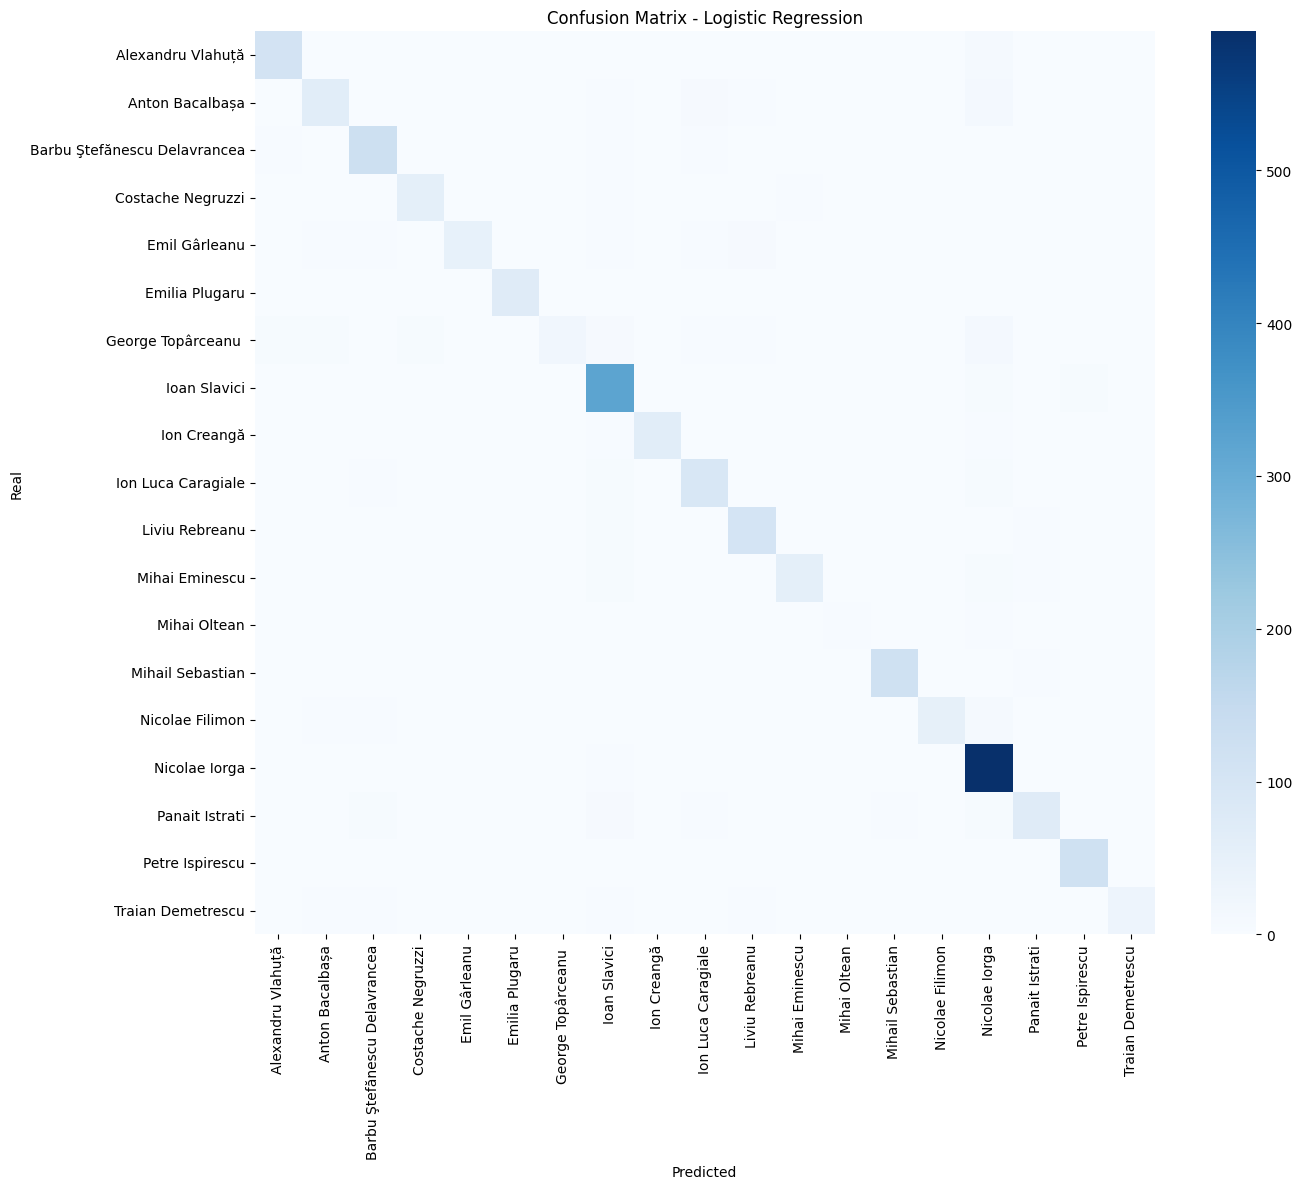


Top 10 cuvinte distinctive per autor:

                               word_1    word_2  word_3     word_4   word_5  \
Alexandru Vlahuță                 lui     țării      de       țara       au   
Anton Bacalbașa                 teacă       don    sînt       cînd    astea   
Barbu Ştefănescu Delavrancea       şi        și   ochii       două     mîna   
Costache Negruzzi                 pre        au      sa     pentru  aceasta   
Emil Gârleanu                 boierul        se   parcă       apoi    dânsa   
Emilia Plugaru                    îşi        nu    doar         şi       va   
George Topârceanu                  cu  deasupra    până        sub      pre   
Ioan Slavici                     grăi      însă      el     gândul       ea   
Ion Creangă                        şi      apoi    iași       iaca   atunci   
Ion Luca Caragiale               zice    foarte      la        zic     până   
Liviu Rebreanu                  acuma     parcă  dânsul       însă    mereu   
Mihai Emines

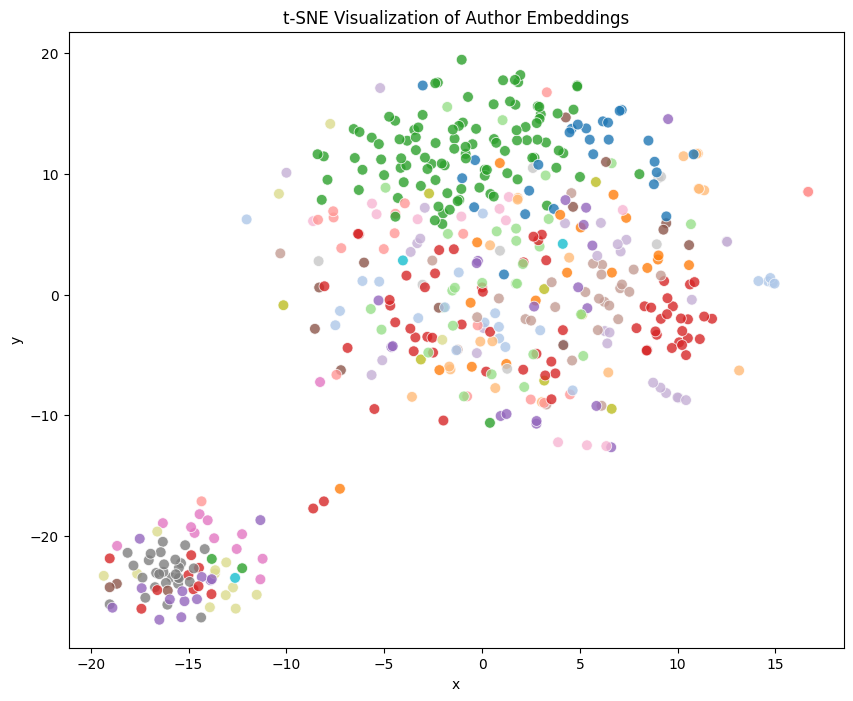

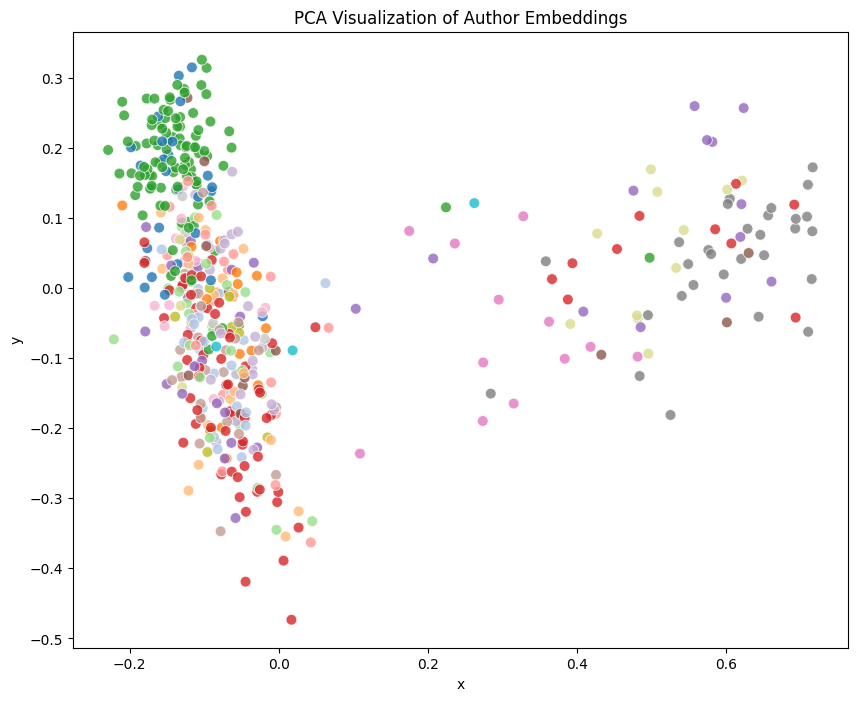

In [17]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 1. Incarcare si preprocesare
df = pd.read_csv("ro_paragraphs_12516.csv")
df = df[df["author"].notnull()]
df = df[df["author"] != "unknown"]

def preprocess(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["paragraph"].astype(str).apply(preprocess)

# 2. TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["clean_text"])
y = df["author"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 3. Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm_df = pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

plt.figure(figsize=(14, 12))
sns.heatmap(cm_df, annot=False, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel("Real")
plt.xlabel("Predicted")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Feature Importance
feature_names = vectorizer.get_feature_names_out()
top_words = {}

for i, author in enumerate(model.classes_):
    top_indices = np.argsort(model.coef_[i])[-10:][::-1]
    top_words[author] = [feature_names[idx] for idx in top_indices]

top_words_df = pd.DataFrame.from_dict(top_words, orient='index', columns=[f"word_{i+1}" for i in range(10)])
print("\nTop 10 cuvinte distinctive per autor:\n")
print(top_words_df)

# 6. t-SNE
X_subset = X_test[:500].toarray()
y_subset = y_test.iloc[:500]
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_subset)

tsne_df = pd.DataFrame()
tsne_df["x"] = X_tsne[:, 0]
tsne_df["y"] = X_tsne[:, 1]
tsne_df["author"] = y_subset.values

plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x="x", y="y", hue="author", palette="tab20", s=60, alpha=0.8, legend=False)
plt.title("t-SNE Visualization of Author Embeddings")
plt.show()

# 7. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_subset)
pca_df = pd.DataFrame()
pca_df["x"] = X_pca[:, 0]
pca_df["y"] = X_pca[:, 1]
pca_df["author"] = y_subset.values

plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x="x", y="y", hue="author", palette="tab20", s=60, alpha=0.8, legend=False)
plt.title("PCA Visualization of Author Embeddings")
plt.show()


Mai jos avem si demo

In [19]:
import ipywidgets as widgets
from IPython.display import display, Markdown

# 1. Functie predictie autor
def predict_author(text_input):
    cleaned = preprocess(text_input)
    vectorized = vectorizer.transform([cleaned])
    pred = model.predict(vectorized)[0]
    display(Markdown(f"###  Autor prezis: **{pred}**"))

# 2. Widget interactiv
text_box = widgets.Textarea(
    value='',
    placeholder='Scrie aici un fragment de text literar...',
    description='Text:',
    layout=widgets.Layout(width='100%', height='100px'),
    disabled=False
)

submit_button = widgets.Button(description="Prezicere autor", button_style='info')

def on_submit(b):
    predict_author(text_box.value)

submit_button.on_click(on_submit)

display(Markdown("##  Demo: Detectie automata a autorului"))
display(text_box, submit_button)


##  Demo: Detectie automata a autorului

Textarea(value='', description='Text:', layout=Layout(height='100px', width='100%'), placeholder='Scrie aici u…

Button(button_style='info', description='Prezicere autor', style=ButtonStyle())

Vizualizari t-SNE si PCA

Structura invatata de modele:

Cele doua diagrame (t-SNE si PCA) ne arata cum sunt pozitionate vectorial fragmentele de text dupa ce au fost procesate de modelul TF-IDF si reduse dimensional. Fiecare punct reprezinta un paragraf, iar culorile diferite corespund autorilor.

t-SNE reuseste sa separe foarte bine clusterele. De exemplu, se poate observa o aglomerare distincta in partea stanga-jos (probabil Nicolae Iorga, care are multe texte si un stil diferit).

PCA, desi mai simplu decat t-SNE, confirma existenta unor grupari semnificative, chiar daca separarea nu este la fel de pronuntata.

Aceste grafice arata ca modelul invata tipare specifice pentru fiecare autor, si ca unii sunt mai usor de separat (au stil distinct), iar altii se suprapun mai mult (stiluri asemanatoare).

Confusion Matrix arata intre cine se incurca modelul, acesta arata pentru Logistic Regression cum a gresit modelul:

De ex:

Nicolae Iorga are un diagonala perfecta, adica este recunoscut aproape fara greseala. Stilul lui este probabil foarte distinct si usor de invatat.

Traian Demetrescu si Mihai Oltean, cu exemple putine si stiluri poate mai comune, au mai multe erori.

Exista confuzii intre autori cu teme si vocabular similar (ex: Caragiale vs. Creanga), dar in general matricea arata ca modelul este stabil si are o performanta consistenta.

Feature Importance ne arata ce cuvinte au contat folosind coeficientii modelului Logistic Regression, s-a extras topul cuvintelor care au avut cea mai mare contributie la identificarea fiecarui autor.

Exemple interesante:

Mihail Sebastian: cuvintele „nora”, „adriana”, „paul” indica teme moderne si personaje recurente.

Nicolae Iorga: cuvinte arhaice si istorice: „supt”, „cari”, „pînă”, „sînt”.

Ion Luca Caragiale: expresii colocviale si stil oral: „zice”, „zic”, „dumneata”, „acuma”.

Eminescu: „aur”, „negru”, „era”, „acu”, un vocabular poetic, metaforic.

Aceste cuvinte ajuta modelul sa traga linia de separatie intre stilurile autorilor. Ele sunt „amprentele lexicale” invatate de algoritm.

Cum invata modelul:
TF-IDF transforma fiecare paragraf intr-un vector care reflecta importanta cuvintelor. Algoritmii invata sa separe acesti vectori in clase, folosind:

Diferente in frecventa unor termeni (de ex. „domn”, „împărat”, „boier” vs. „adriana”, „gelu”, „nora”)

Asociatii unice: un autor foloseste expresii sau teme specifice, care il diferentiaza

Lungimea, constructia frazelor, si prezenta cuvintelor de legatura influenteaza si ele.



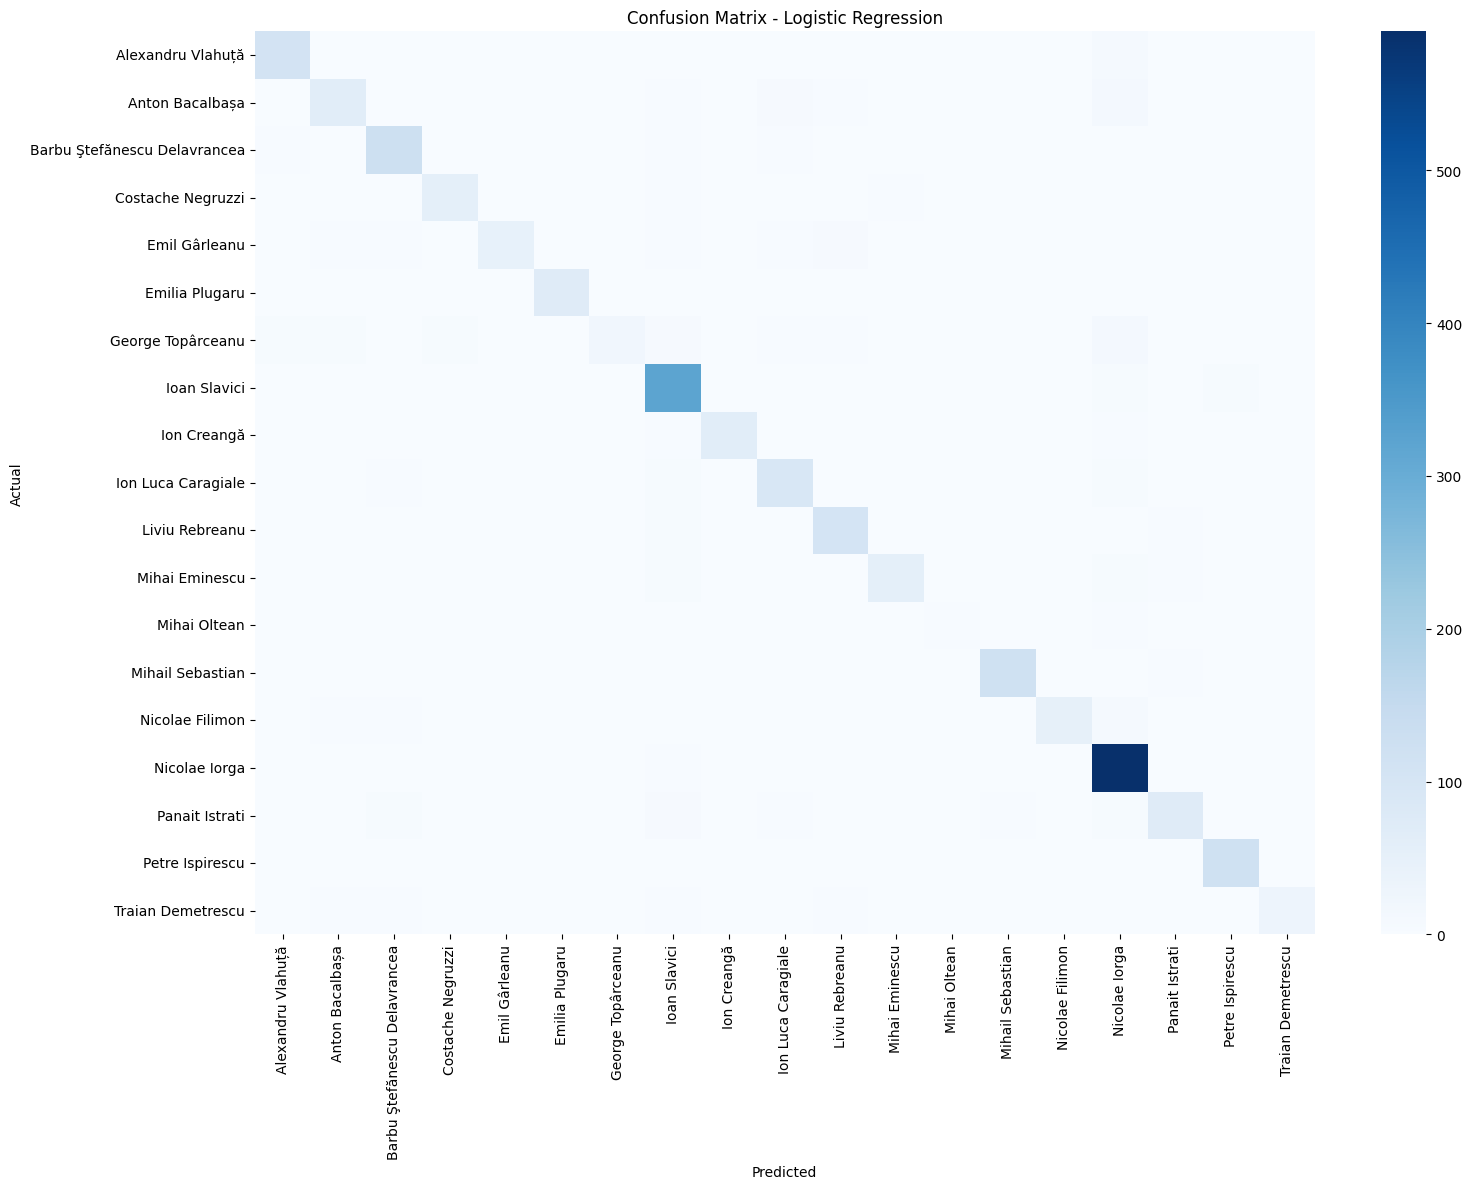


Top 10 cuvinte distinctive pentru Alexandru Vlahuță:
 - lui
 - țării
 - de
 - țara
 - au
 - valea
 - și
 - turcii
 - pe
 - din

Top 10 cuvinte distinctive pentru Anton Bacalbașa:
 - teacă
 - don
 - sînt
 - cînd
 - astea
 - asta
 - moș
 - decît
 - care
 - toate

Top 10 cuvinte distinctive pentru Barbu Ştefănescu Delavrancea:
 - şi
 - și
 - ochii
 - două
 - mîna
 - cînd
 - da
 - mi
 - vin
 - fi

Top 10 cuvinte distinctive pentru Costache Negruzzi:
 - pre
 - au
 - sa
 - pentru
 - aceasta
 - său
 - precum
 - voi
 - lor
 - sale

Top 10 cuvinte distinctive pentru Emil Gârleanu:
 - boierul
 - se
 - parcă
 - apoi
 - dânsa
 - își
 - femeia
 - cum
 - repede
 - bătrânul

Top 10 cuvinte distinctive pentru Emilia Plugaru:
 - îşi
 - nu
 - doar
 - şi
 - va
 - atât
 - sunt
 - alături
 - strigă
 - îi

Top 10 cuvinte distinctive pentru George Topârceanu:
 - cu
 - deasupra
 - până
 - sub
 - pre
 - numai
 - au
 - capul
 - vodă
 - marginea

Top 10 cuvinte distinctive pentru Ioan Slavici:
 - grăi
 - însă
 

In [20]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# 1. Incarcam si curatam datele
df = pd.read_csv("ro_paragraphs_12516.csv")
df = df[df["author"].notnull() & (df["author"] != "unknown")]
df["author"] = df["author"].str.strip()

def preprocess(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["paragraph"].astype(str).apply(preprocess)

# 2. TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df["clean_text"])
feature_names = tfidf.get_feature_names_out()

# 3. Encode authors
le = LabelEncoder()
y = le.fit_transform(df["author"])
labels = le.classes_

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 5. Model logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(16, 12))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=False, cmap="Blues", fmt='g')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 7. Feature Importance per author
coefs = model.coef_

# pentru fiecare autor afisam top 10 cuvinte
for i, author in enumerate(labels):
    top10_idx = np.argsort(coefs[i])[-10:]
    top_words = [feature_names[j] for j in top10_idx][::-1]
    print(f"\nTop 10 cuvinte distinctive pentru {author}:")
    for word in top_words:
        print(f" - {word}")


In [21]:
import pandas as pd

# Dictionar cu autorii si cuvintele lor distinctive
feature_data = {
    "Alexandru Vlahuță": ["lui", "țării", "de", "țara", "au", "valea", "și", "turcii", "pe", "din"],
    "Anton Bacalbașa": ["teacă", "don", "sînt", "cînd", "astea", "asta", "moș", "decît", "care", "toate"],
    "Barbu Ştefănescu Delavrancea": ["şi", "și", "ochii", "două", "mîna", "cînd", "da", "mi", "vin", "fi"],
    "Costache Negruzzi": ["pre", "au", "sa", "pentru", "aceasta", "său", "precum", "voi", "lor", "sale"],
    "Emil Gârleanu": ["boierul", "se", "parcă", "apoi", "dânsa", "își", "femeia", "cum", "repede", "bătrânul"],
    "Emilia Plugaru": ["îşi", "nu", "doar", "şi", "va", "atât", "sunt", "alături", "strigă", "îi"],
    "George Topârceanu": ["cu", "deasupra", "până", "sub", "pre", "numai", "au", "capul", "vodă", "marginea"],
    "Ioan Slavici": ["grăi", "însă", "el", "gândul", "ea", "ci", "persida", "era", "şi", "iară"],
    "Ion Creangă": ["şi", "apoi", "iași", "iaca", "atunci", "vă", "măi", "acum", "ia", "vasile"],
    "Ion Luca Caragiale": ["zice", "foarte", "la", "zic", "până", "dumneata", "încet", "acuma", "pe", "așa"],
    "Liviu Rebreanu": ["acuma", "parcă", "dânsul", "însă", "mereu", "și", "totuși", "că", "se", "deodată"],
    "Mihai Eminescu": ["el", "aur", "era", "acu", "ea", "pân", "da", "încet", "negru", "tu"],
    "Mihai Oltean": ["si", "oamenii", "încât", "ceva", "atât", "in", "le", "doar", "plină", "oamenilor"],
    "Mihail Sebastian": ["nora", "adriana", "paul", "gelu", "era", "târziu", "care", "ei", "ștefan", "zăpadă"],
    "Nicolae Filimon": ["sale", "cînd", "decît", "ce", "pînă", "dete", "cele", "iar", "atît", "este"],
    "Nicolae Iorga": ["care", "cari", "supt", "sînt", "al", "pentru", "cînd", "sânt", "pănă", "pînă"],
    "Panait Istrati": ["adrian", "asta", "decât", "ăsta", "ne", "care", "să", "nimic", "mama", "mele"],
    "Petre Ispirescu": ["şi", "dară", "iară", "se", "dete", "văzu", "să", "fata", "este", "dânsul"],
    "Traian Demetrescu": ["cari", "par", "un", "totdeauna", "mă", "îmi", "femeie", "stradă", "unei", "femeile"]
}

# Transformam in DataFrame
df = pd.DataFrame.from_dict(feature_data, orient="index", columns=[f"word_{i+1}" for i in range(10)])
print(df.to_string())


                               word_1    word_2  word_3     word_4   word_5    word_6   word_7   word_8  word_9    word_10
Alexandru Vlahuță                 lui     țării      de       țara       au     valea       și   turcii      pe        din
Anton Bacalbașa                 teacă       don    sînt       cînd    astea      asta      moș    decît    care      toate
Barbu Ştefănescu Delavrancea       şi        și   ochii       două     mîna      cînd       da       mi     vin         fi
Costache Negruzzi                 pre        au      sa     pentru  aceasta       său   precum      voi     lor       sale
Emil Gârleanu                 boierul        se   parcă       apoi    dânsa       își   femeia      cum  repede   bătrânul
Emilia Plugaru                    îşi        nu    doar         şi       va      atât     sunt  alături  strigă         îi
George Topârceanu                  cu  deasupra    până        sub      pre     numai       au    capul    vodă   marginea
Ioan Slavici    

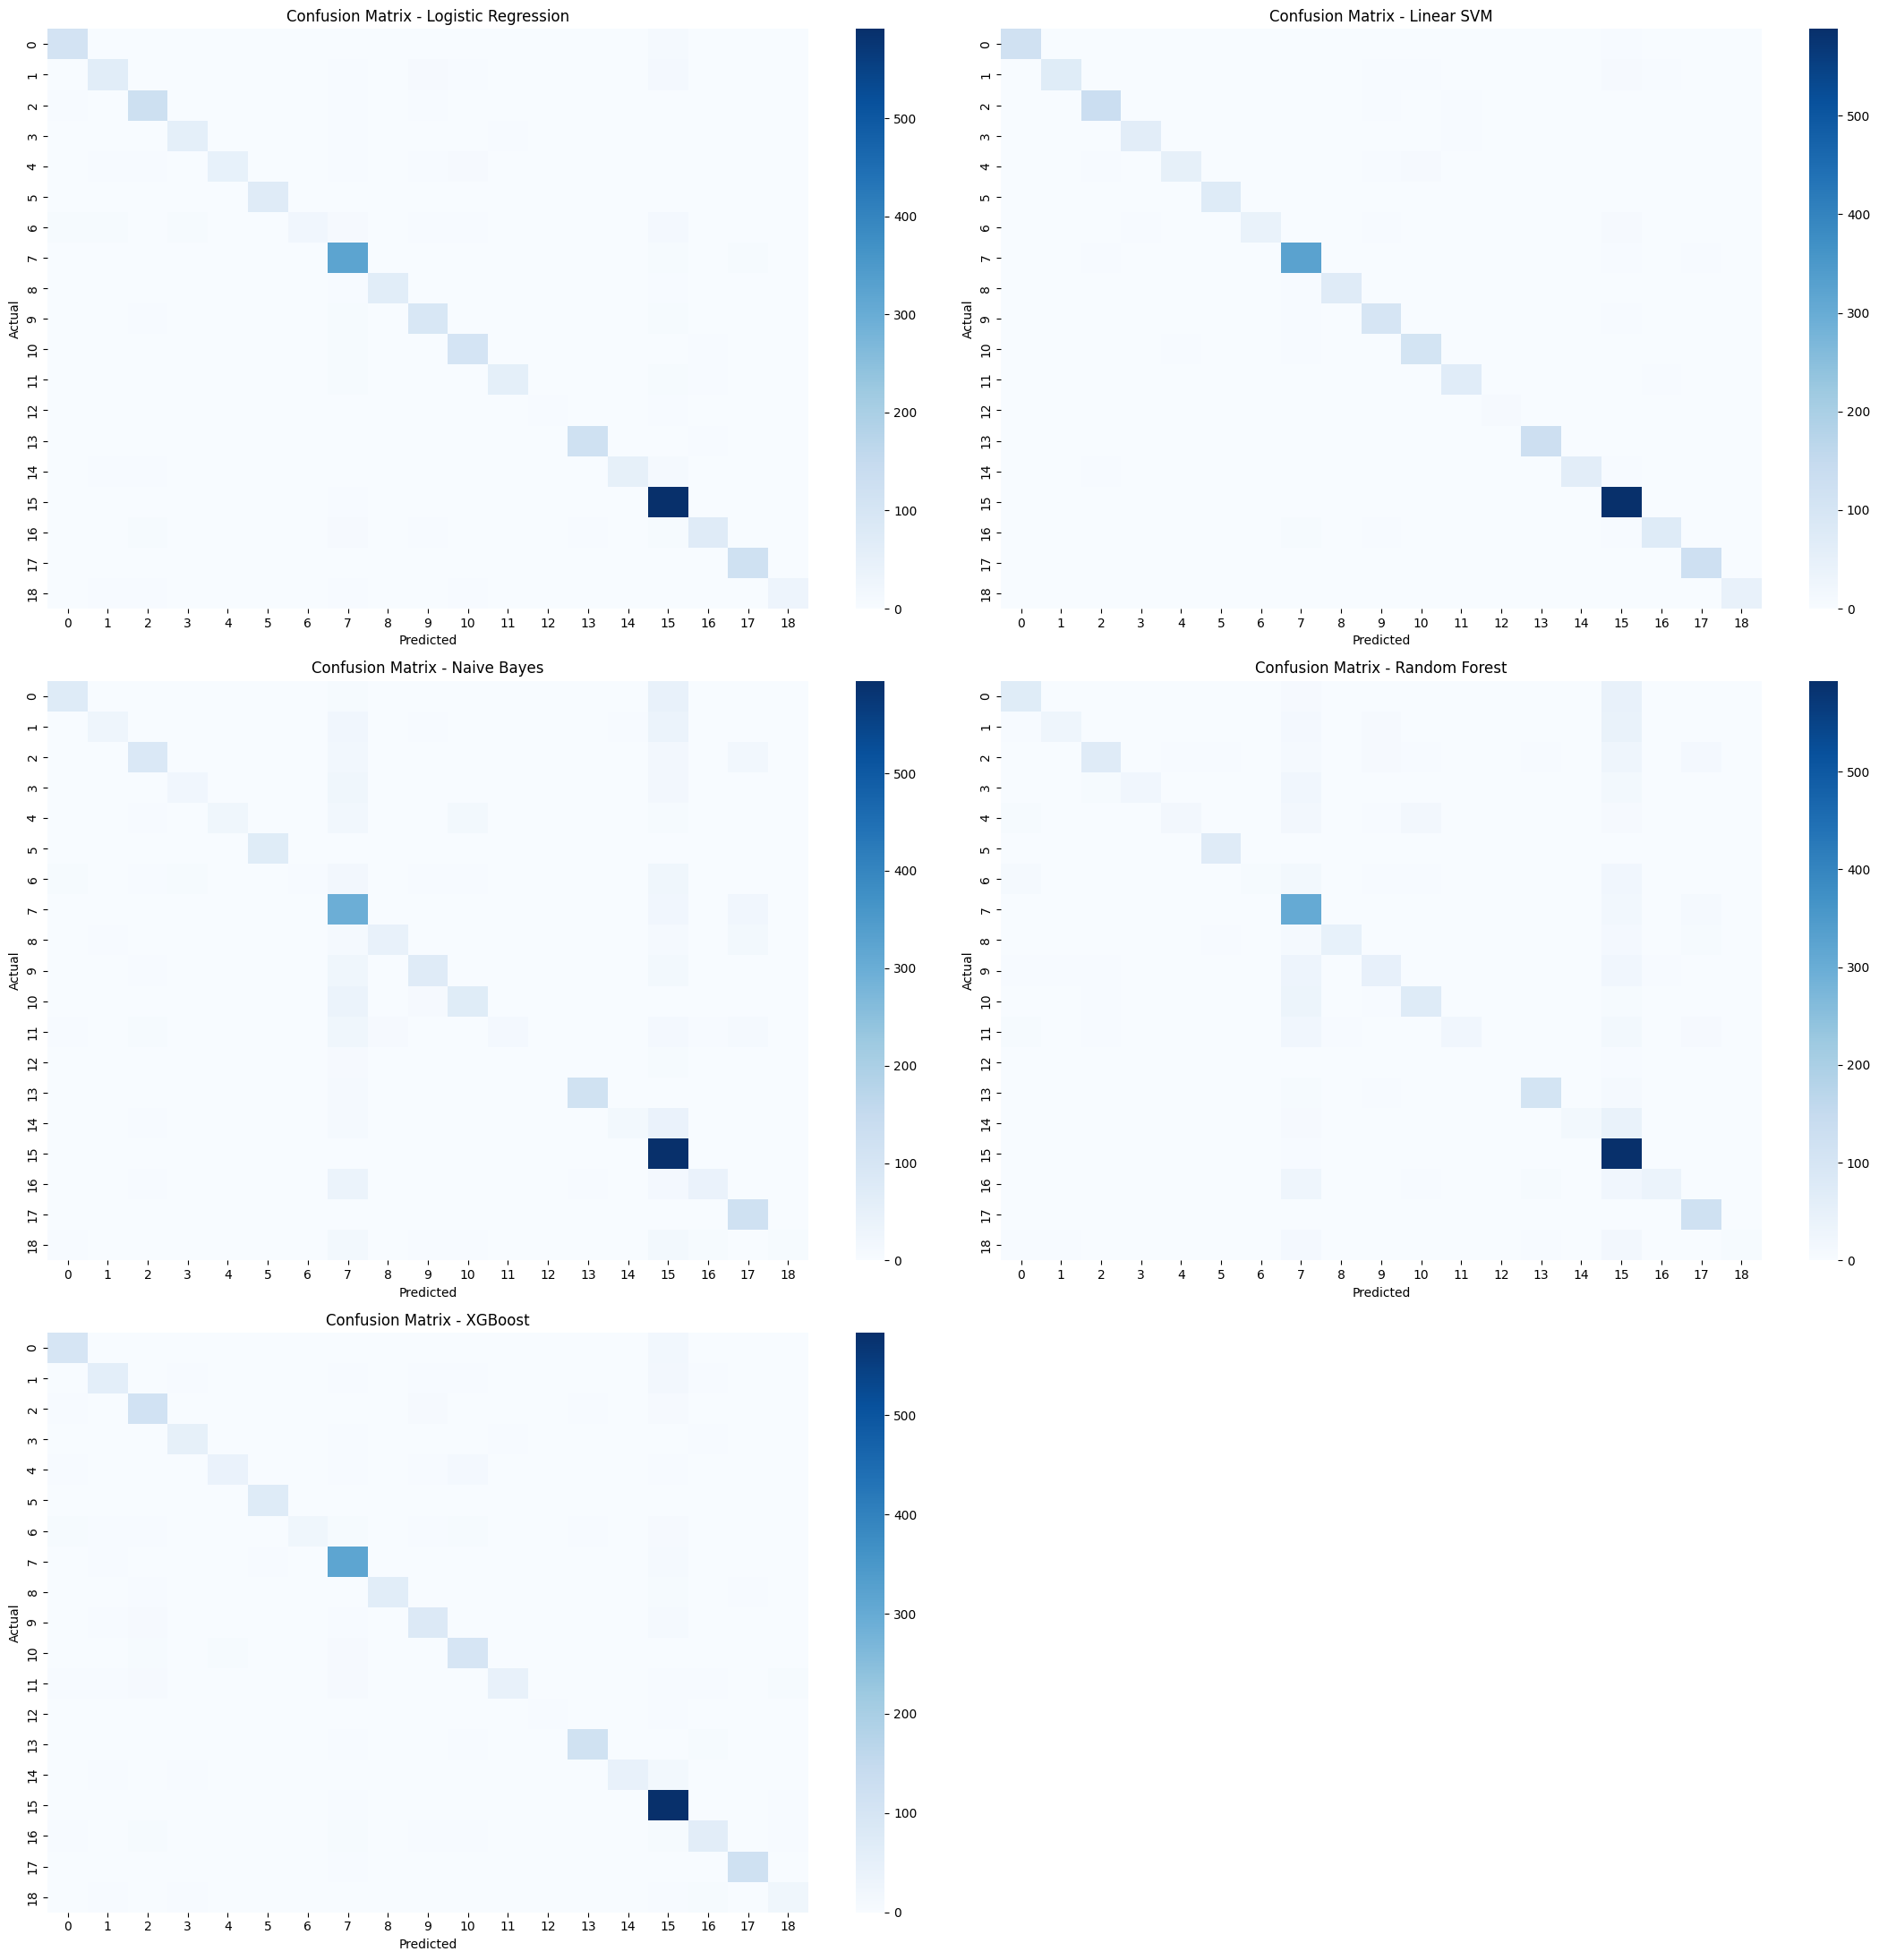

In [23]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Linear SVM": LinearSVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Modele initialize
lr_model = LogisticRegression(max_iter=1000)
svm_model = LinearSVC()
nb_model = MultinomialNB()
rf_model = RandomForestClassifier(n_estimators=100)
xgb_model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

# Antrenare
lr_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

model_dict = {
    "Logistic Regression": lr_model,
    "Linear SVM": svm_model,
    "Naive Bayes": nb_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

fig, axes = plt.subplots(3, 2, figsize=(22, 22))
axes = axes.flatten()

for idx, (name, model) in enumerate(model_dict.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", ax=axes[idx],
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    axes[idx].set_title(f"Confusion Matrix - {name}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

# Sterge ultima axa daca sunt doar 5 modele
if len(model_dict) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_nice(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels,
                cbar_kws={"shrink": 0.75}, linewidths=0.5, linecolor='gray')
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

